# D206 Paris Performance Assessment

## C1: Quality Assessment Plan

In [1]:
# install all necessary libraries just in case
# %pip install fancyimpute  # downgrades scipy
# %pip install matplotlib
# %pip install missingno
# %pip install numpy
# %pip install pandas
# %pip install pyarrow
# %pip install seaborn
# %pip install scikit-learn
# %pip install scipy

In [2]:
# import necessary modules
import shutil
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from fancyimpute import KNN
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [3]:
# make a backup of the data
# WARNING - this is a destructive process, medical_raw_data_working.csv WILL be
# overwritten if it exists
original_data_file = Path("medical_raw_data.csv")
working_data_file = shutil.copy(original_data_file, Path("medical_raw_data_working.csv"))

patients_df = pd.read_csv(working_data_file, index_col=0)

In [4]:
# get the dimensions of the dataset
print(patients_df.shape)

(10000, 52)


In [5]:
# get the column names to see what we're working with
print(patients_df.columns)

Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'Timezone', 'Job',
       'Children', 'Age', 'Education', 'Employment', 'Income', 'Marital',
       'Gender', 'ReAdmis', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten',
       'VitD_supp', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
       'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
       'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
       'Reflux_esophagitis', 'Asthma', 'Services', 'Initial_days',
       'TotalCharge', 'Additional_charges', 'Item1', 'Item2', 'Item3', 'Item4',
       'Item5', 'Item6', 'Item7', 'Item8'],
      dtype='object')


In [6]:
# compute basic statistics for the dataset
print(patients_df.describe())

         CaseOrder           Zip           Lat           Lng     Population  \
count  10000.00000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    5000.50000  50159.323900     38.751099    -91.243080    9965.253800   
std     2886.89568  27469.588208      5.403085     15.205998   14824.758614   
min        1.00000    610.000000     17.967190   -174.209690       0.000000   
25%     2500.75000  27592.000000     35.255120    -97.352982     694.750000   
50%     5000.50000  50207.000000     39.419355    -88.397230    2769.000000   
75%     7500.25000  72411.750000     42.044175    -80.438050   13945.000000   
max    10000.00000  99929.000000     70.560990    -65.290170  122814.000000   

          Children          Age         Income   VitD_levels    Doc_visits  \
count  7412.000000  7586.000000    7536.000000  10000.000000  10000.000000   
mean      2.098219    53.295676   40484.438268     19.412675      5.012200   
std       2.155427    20.659182   28664.861050      6.

In [7]:
# display the first five rows of the dataset
print(patients_df.head())

   CaseOrder Customer_id                           Interaction  \
1          1     C412403  8cd49b13-f45a-4b47-a2bd-173ffa932c2f   
2          2     Z919181  d2450b70-0337-4406-bdbb-bc1037f1734c   
3          3     F995323  a2057123-abf5-4a2c-abad-8ffe33512562   
4          4     A879973  1dec528d-eb34-4079-adce-0d7a40e82205   
5          5     C544523  5885f56b-d6da-43a3-8760-83583af94266   

                                UID          City State        County    Zip  \
1  3a83ddb66e2ae73798bdf1d705dc0932           Eva    AL        Morgan  35621   
2  176354c5eef714957d486009feabf195      Marianna    FL       Jackson  32446   
3  e19a0fa00aeda885b8a436757e889bc9   Sioux Falls    SD     Minnehaha  57110   
4  cd17d7b6d152cb6f23957346d11c3f07  New Richland    MN        Waseca  56072   
5  d2f0425877b10ed6bb381f3e2579424a    West Point    VA  King William  23181   

        Lat       Lng  ...  TotalCharge Additional_charges Item1 Item2  Item3  \
1  34.34960 -86.72508  ...  3191.048774  

## D1: Findings

### Search for duplicate observations

Since `CaseOrder` was generated we will ignore it working under the assumption that any existing duplicate observations would have had a unique `CaseOrder` created for it. We will check `CaseOrder` for duplicates in the next step.

In [8]:
observation_data = patients_df.iloc[:, 1:].columns.tolist()

duplicated_observarions = patients_df[patients_df.duplicated(subset=observation_data)]

if not duplicated_observarions.empty:
    print("Duplicate observations found.")
    print(duplicated_observarions)
else:
    print("No duplicated observations found.")

No duplicated observations found.


### Search for duplicate values in variables that should be unique

`CaseOrder`, `Customer_id`, `Interaction`, and `UID` should all be unique. A duplicated value in any of these columns means faulty data.

In [9]:
# check for duplicated values in variables that should be unique
unique_variables = patients_df.iloc[:, :4].columns.tolist()
# unique_variables.append("Timezone")

for variable in unique_variables:
    duplicated_values = patients_df[patients_df.duplicated(subset=[variable])]

    if not duplicated_values.empty:
        duplicates_counter = Counter(duplicated_values[variable])

        print(f"Duplicate values found in {variable}")
        for var, count in sorted(duplicates_counter.items()):
            print(f"\t{var} appears {count} times.")
    else:
        print(f"No duplicated values found in the {variable} column.")

No duplicated values found in the CaseOrder column.
No duplicated values found in the Customer_id column.
No duplicated values found in the Interaction column.
No duplicated values found in the UID column.


### Search for missing values

We check for missing values using the DataFrame's `.info()` method.

In [10]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  Timezone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            7412 non-null   float64
 15  Age                 7586 non-null   float64
 16  Education

`.info()` shows us that there are 10,000 observations in the dataset and that there are several variables that contain less than 10,000 non-null values. Let's get a list of just those variables.

In [11]:
variables_with_nulls = sorted([column for column in patients_df.columns if patients_df[column].isna().sum() != 0])

print("The following variables contain null values: " + ", ".join(variables_with_nulls))

The following variables contain null values: Age, Anxiety, Children, Income, Initial_days, Overweight, Soft_drink


Let's quickly see how many missing values there are for each variable.

In [12]:
num_observations = len(patients_df)

for column in patients_df.columns:
    num_missing_values = patients_df[column].isna().sum()
    if num_missing_values != 0:
        print(f"{column}: {num_missing_values}")

Children: 2588
Age: 2414
Income: 2464
Soft_drink: 2467
Overweight: 982
Anxiety: 984
Initial_days: 1056


Let's visualize the missing data using a nullity matrix in order to attempt to determine the kind of missingness.

<Axes: >

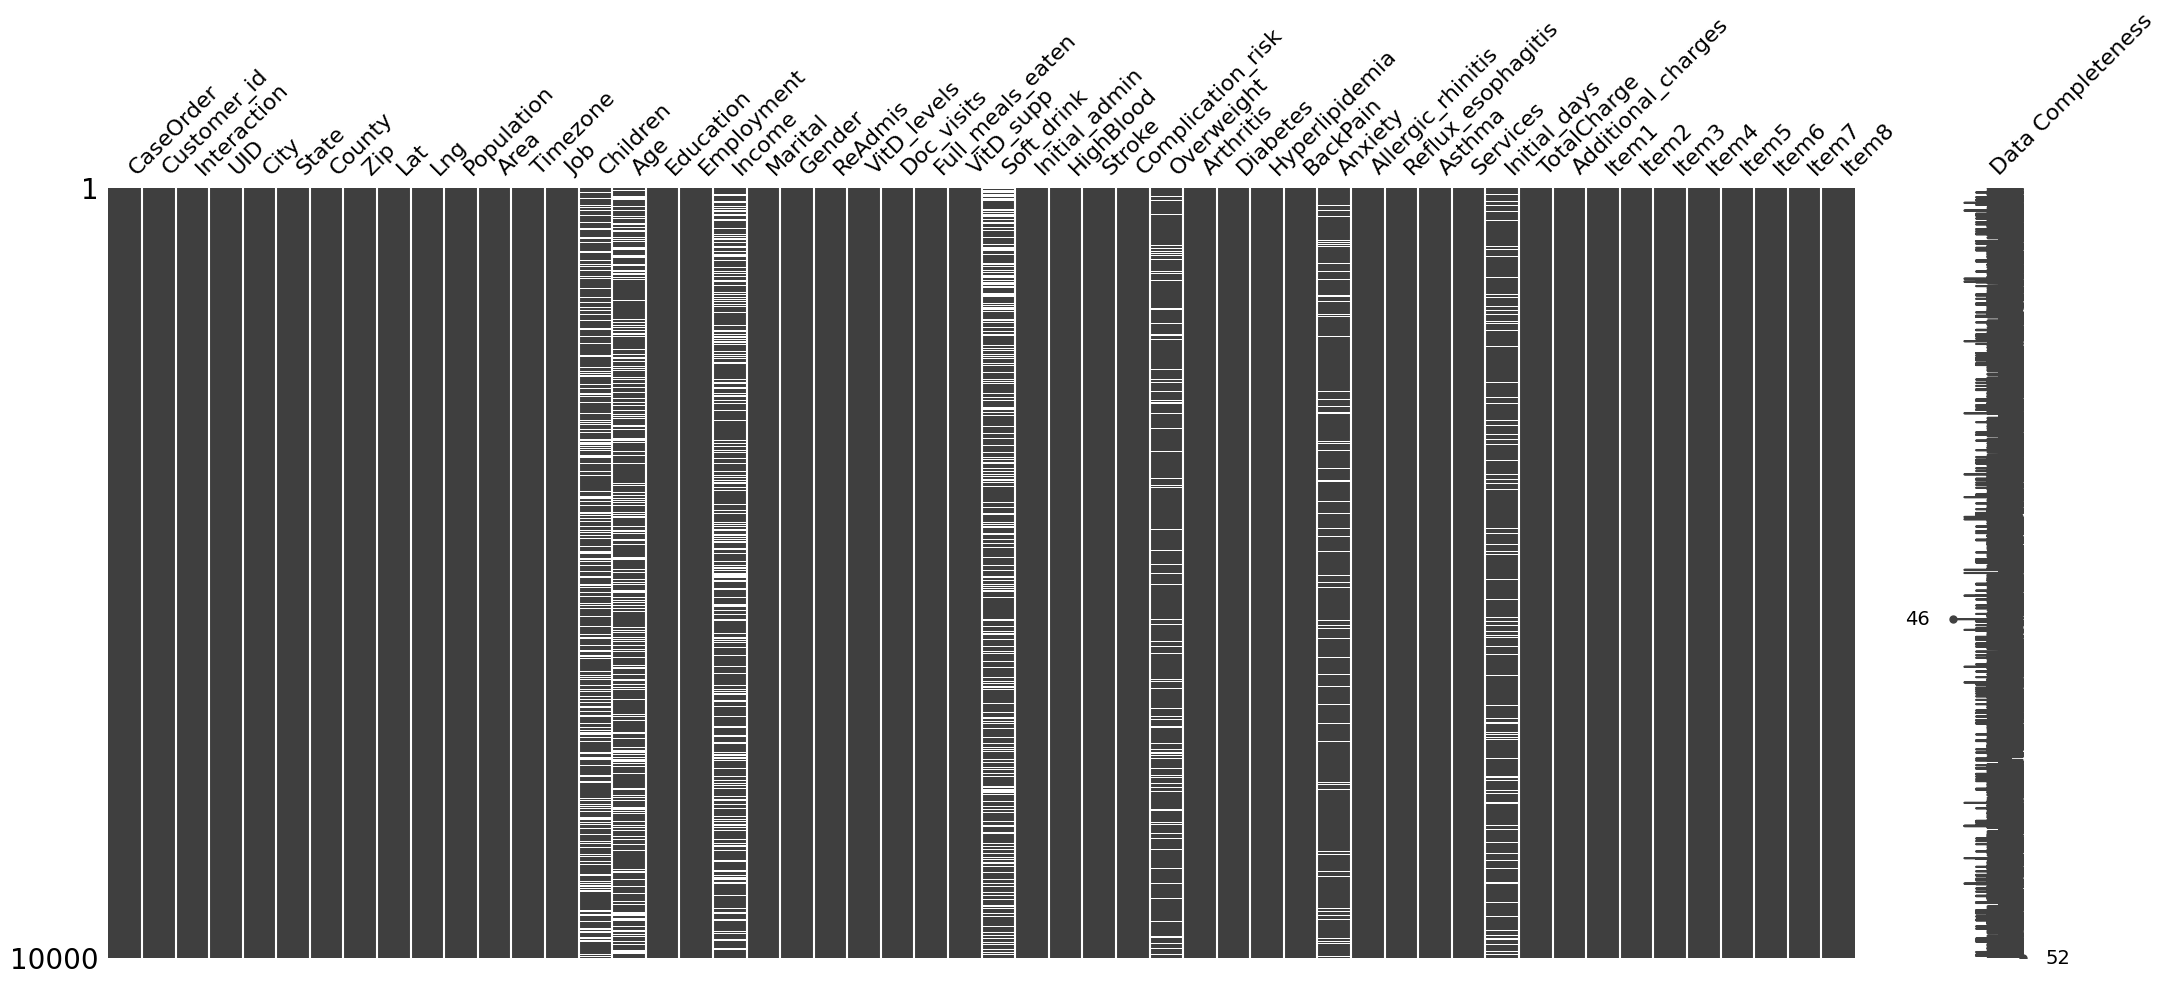

In [13]:
msno.matrix(patients_df, labels=True)

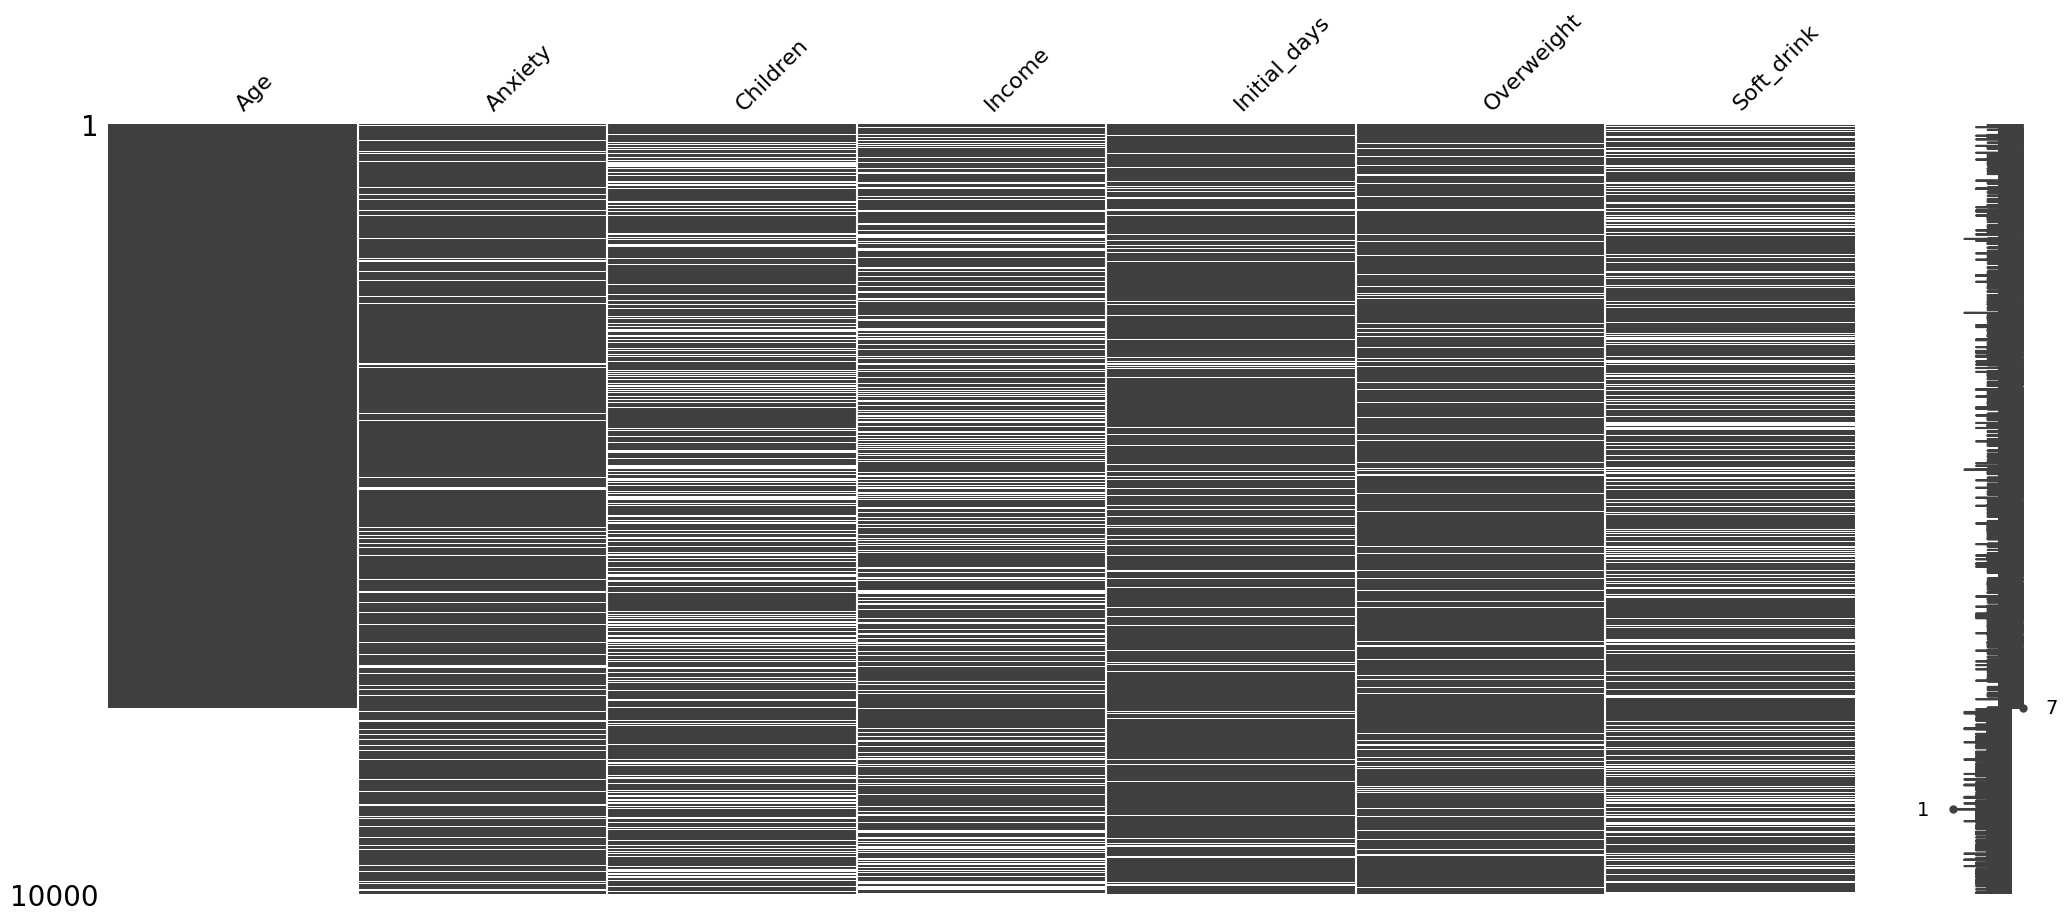

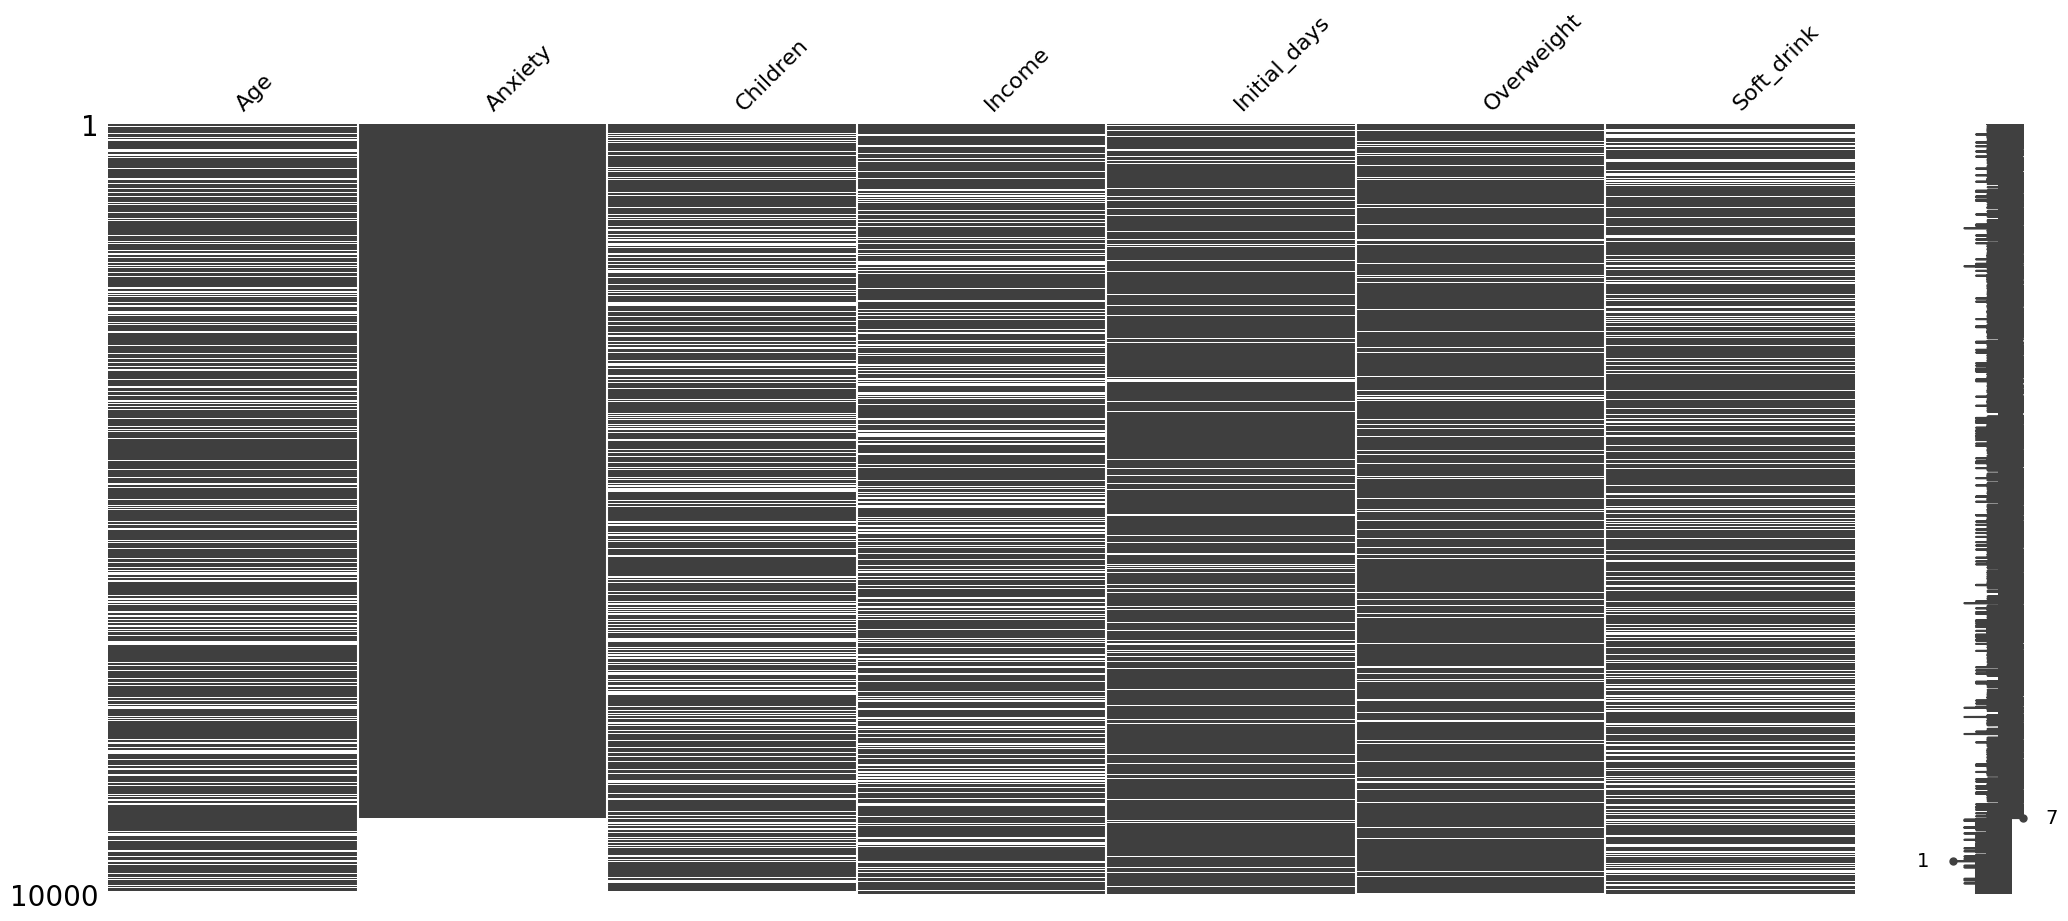

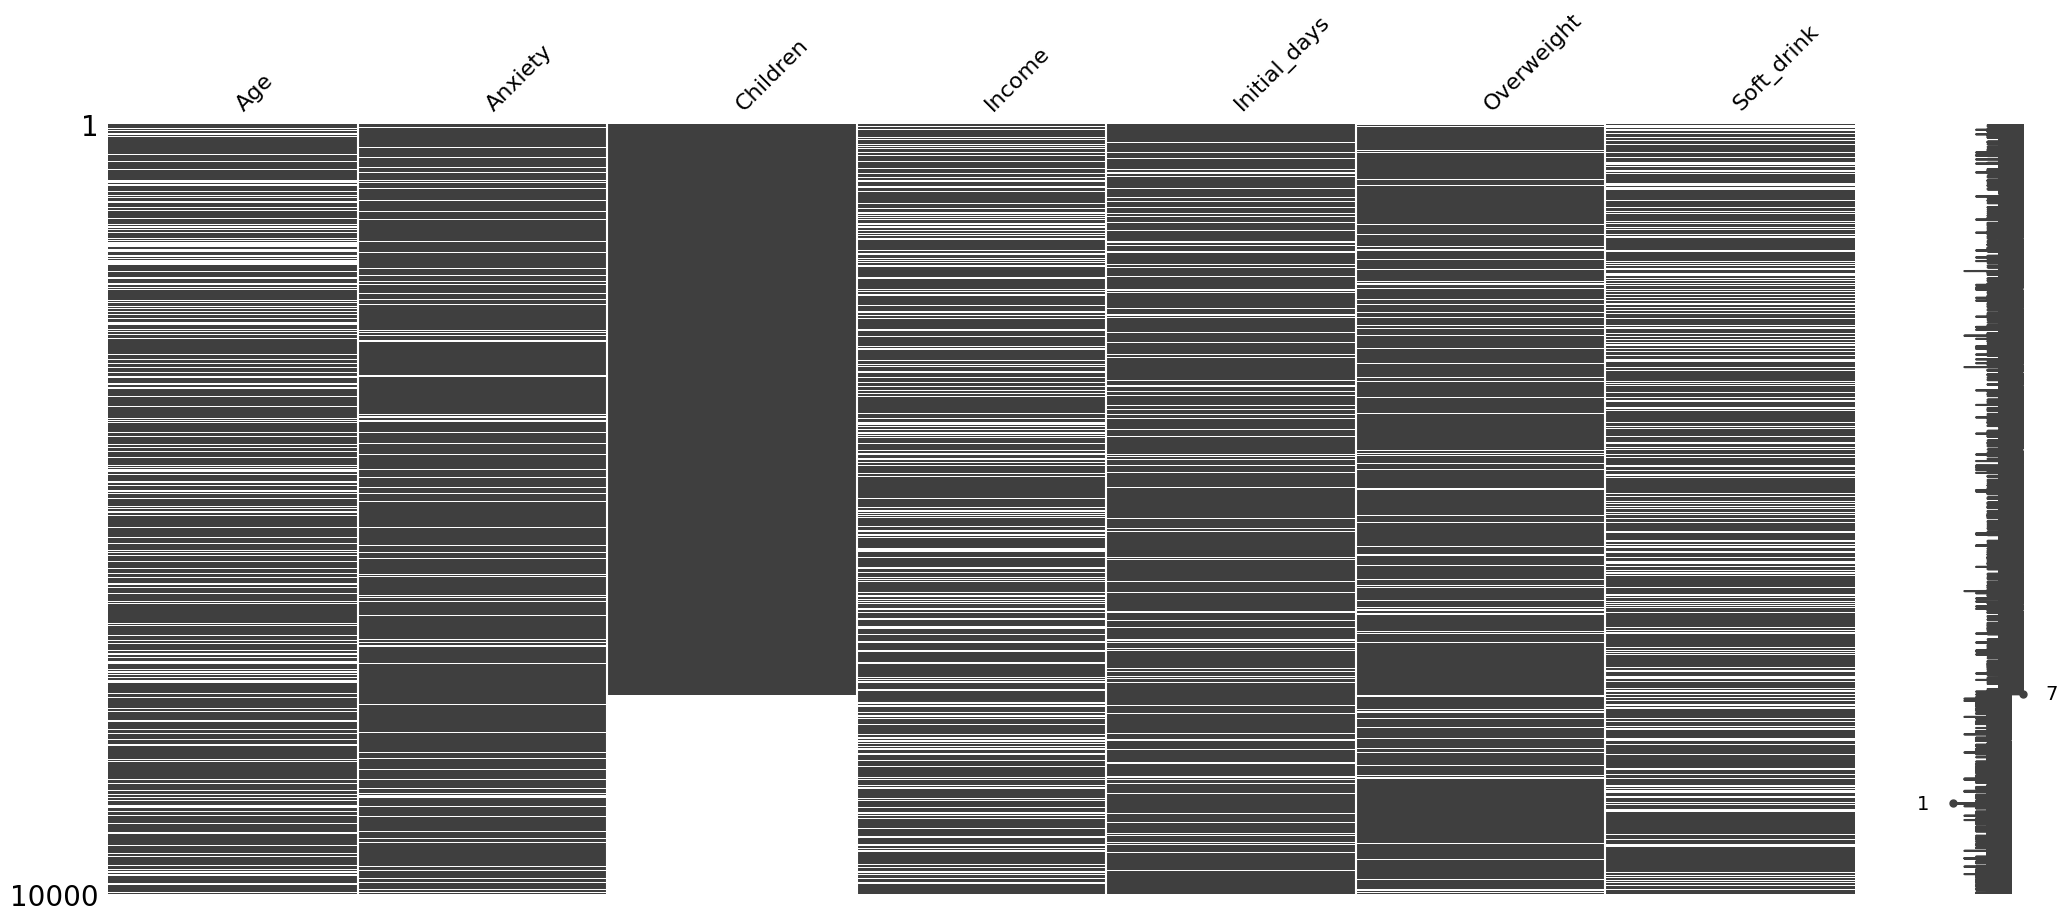

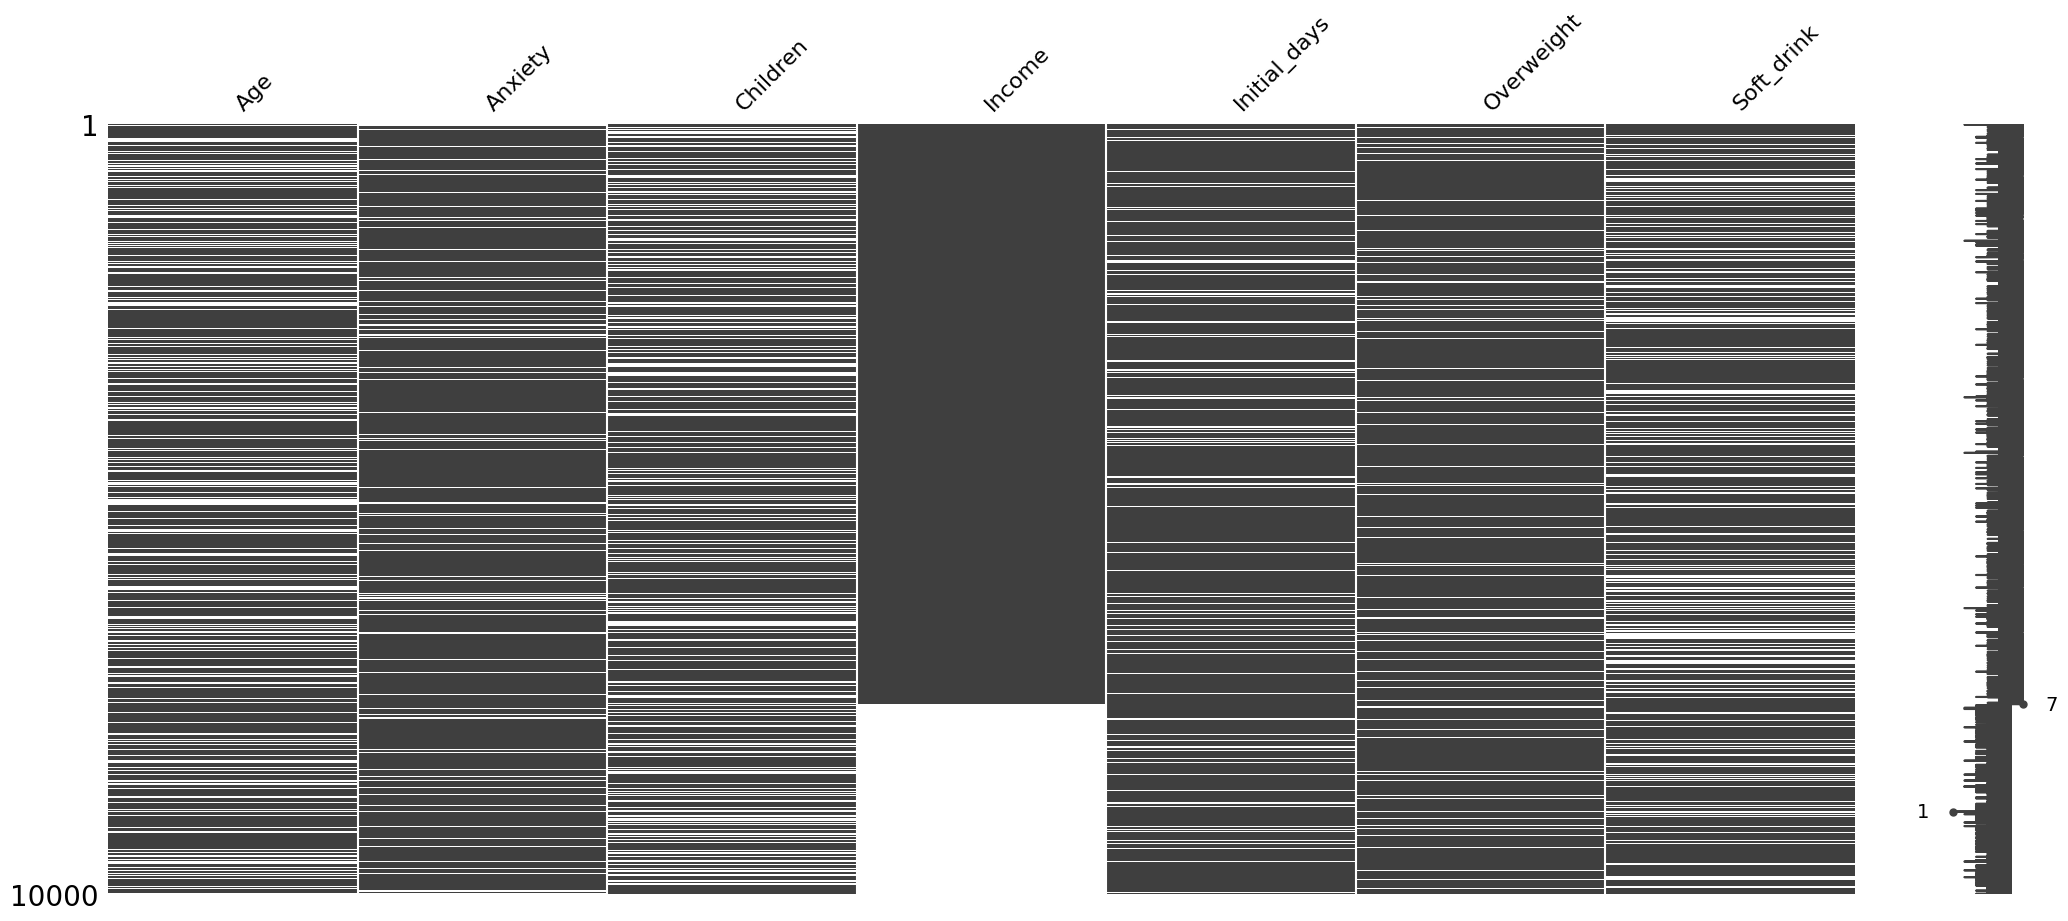

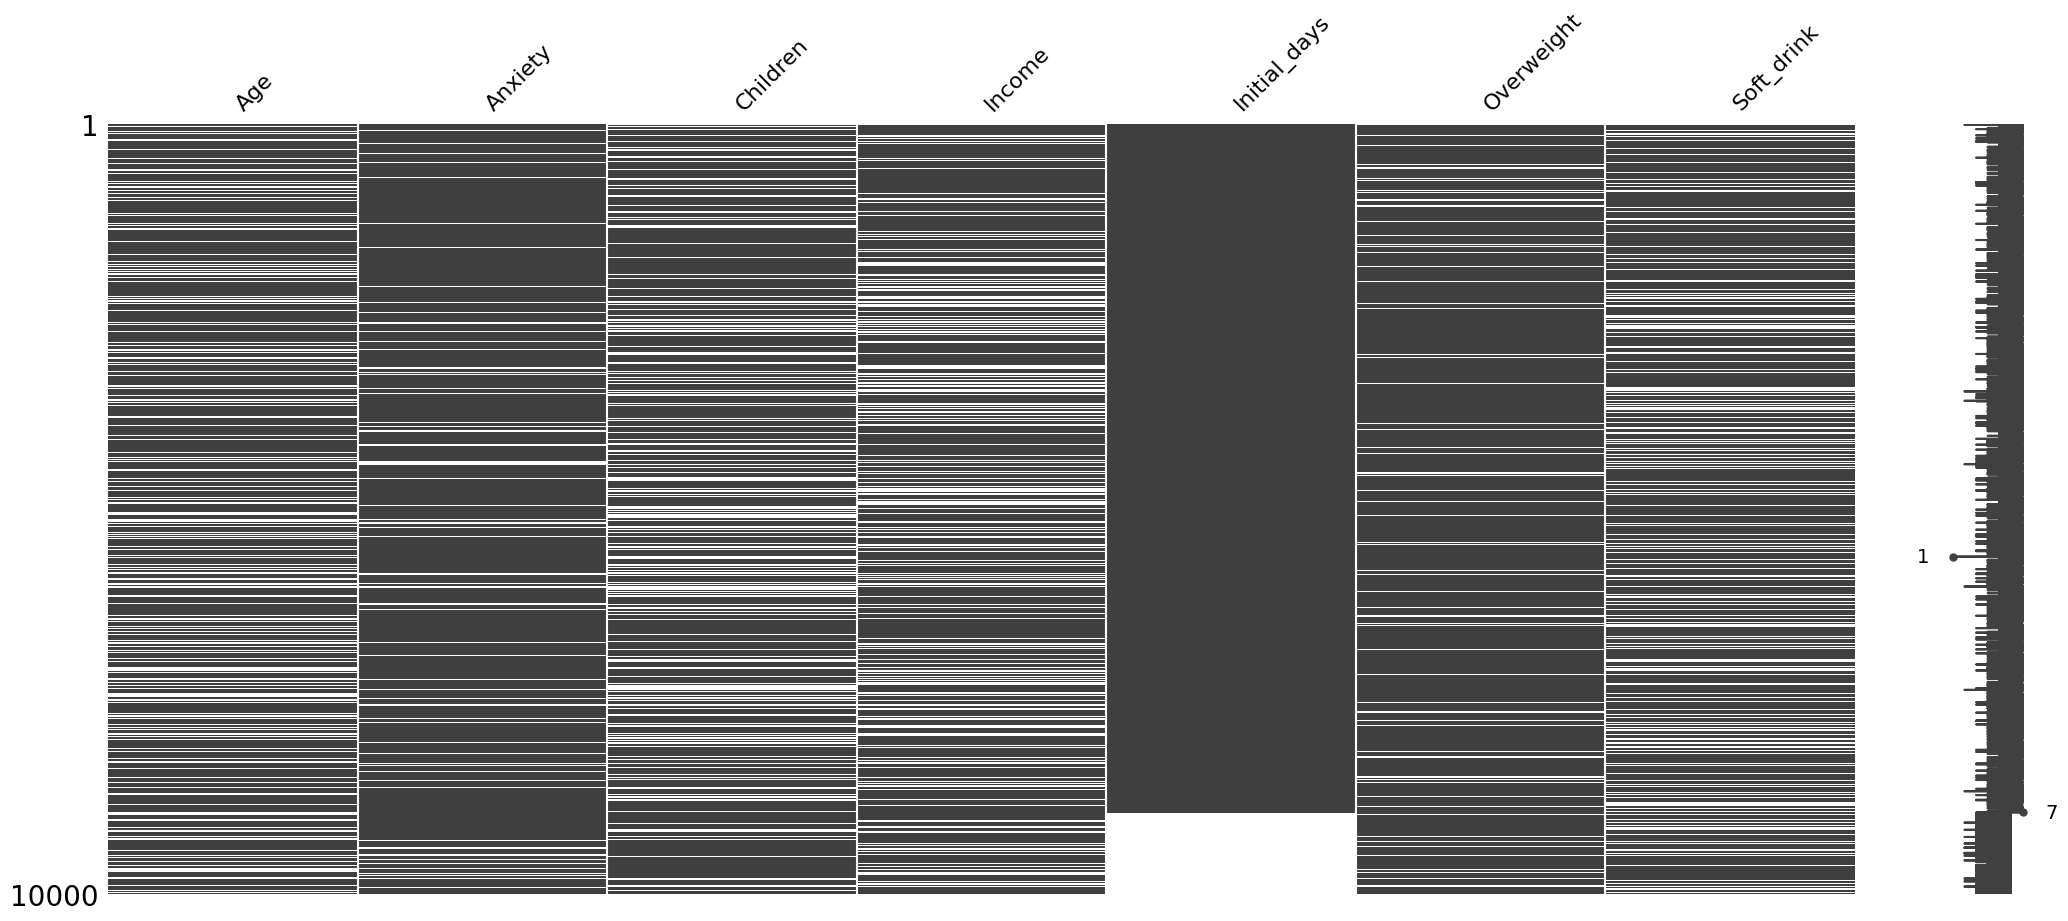

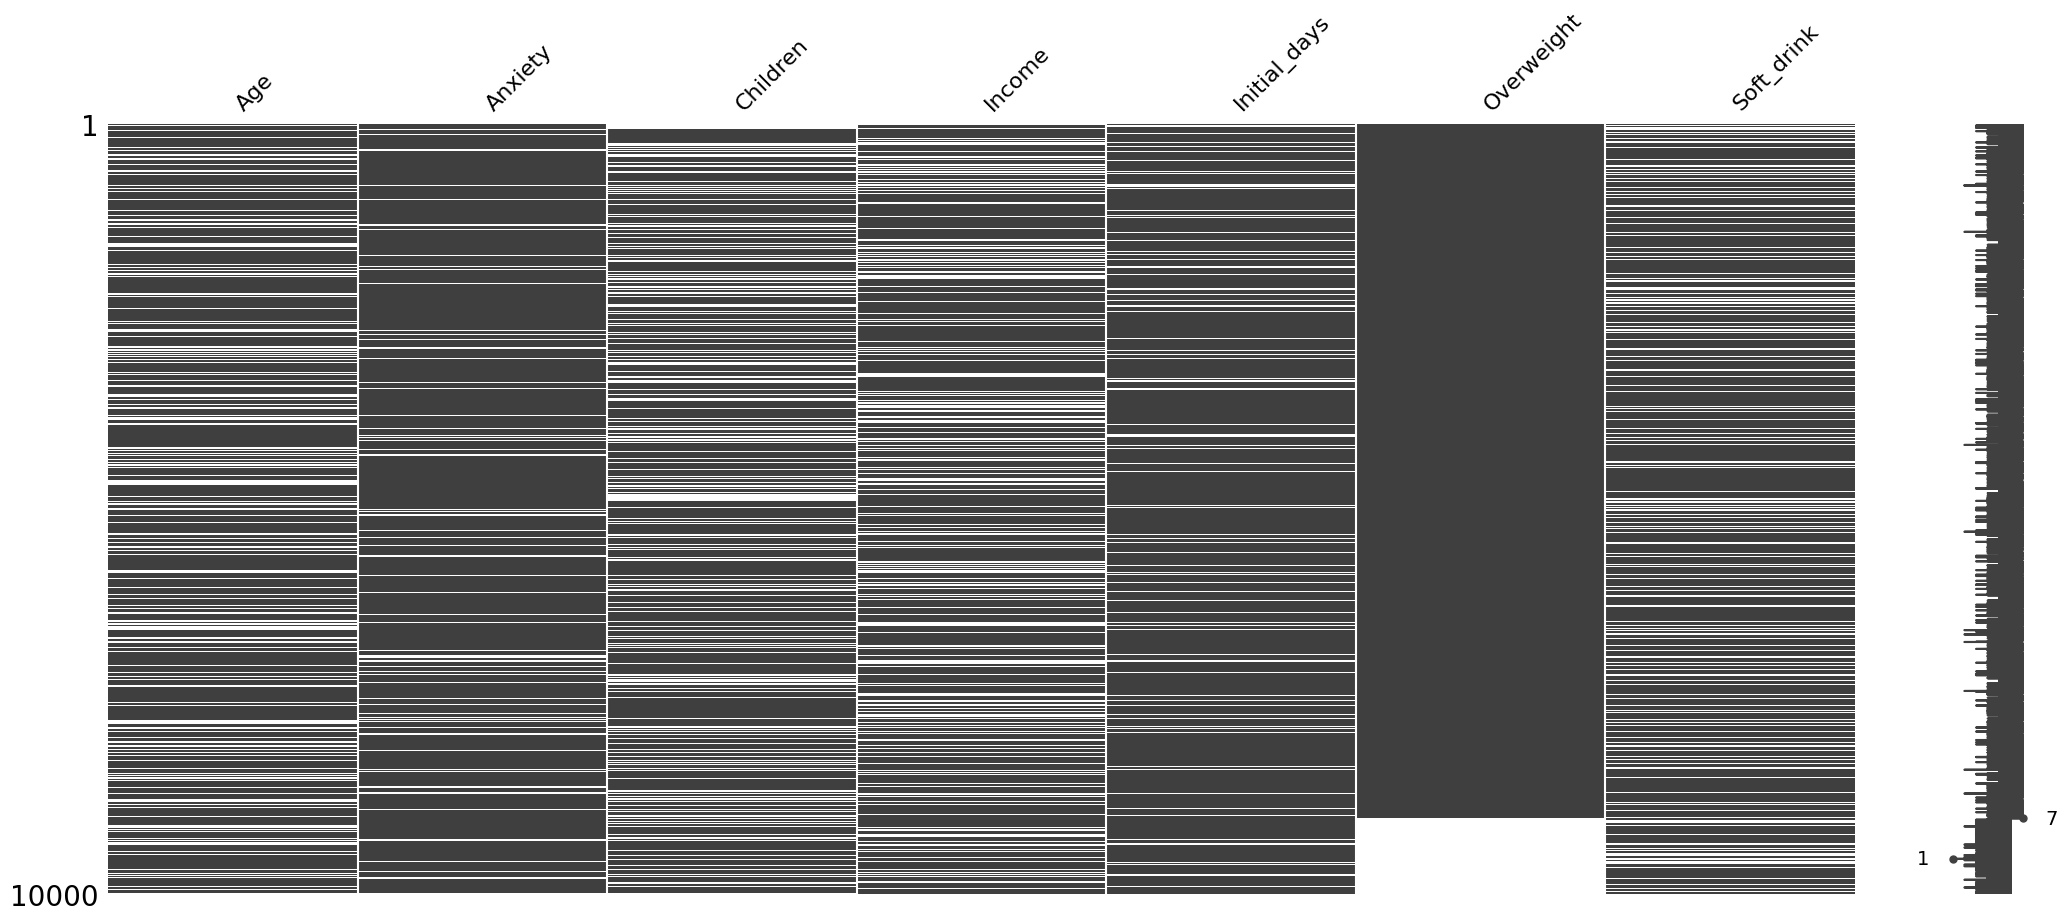

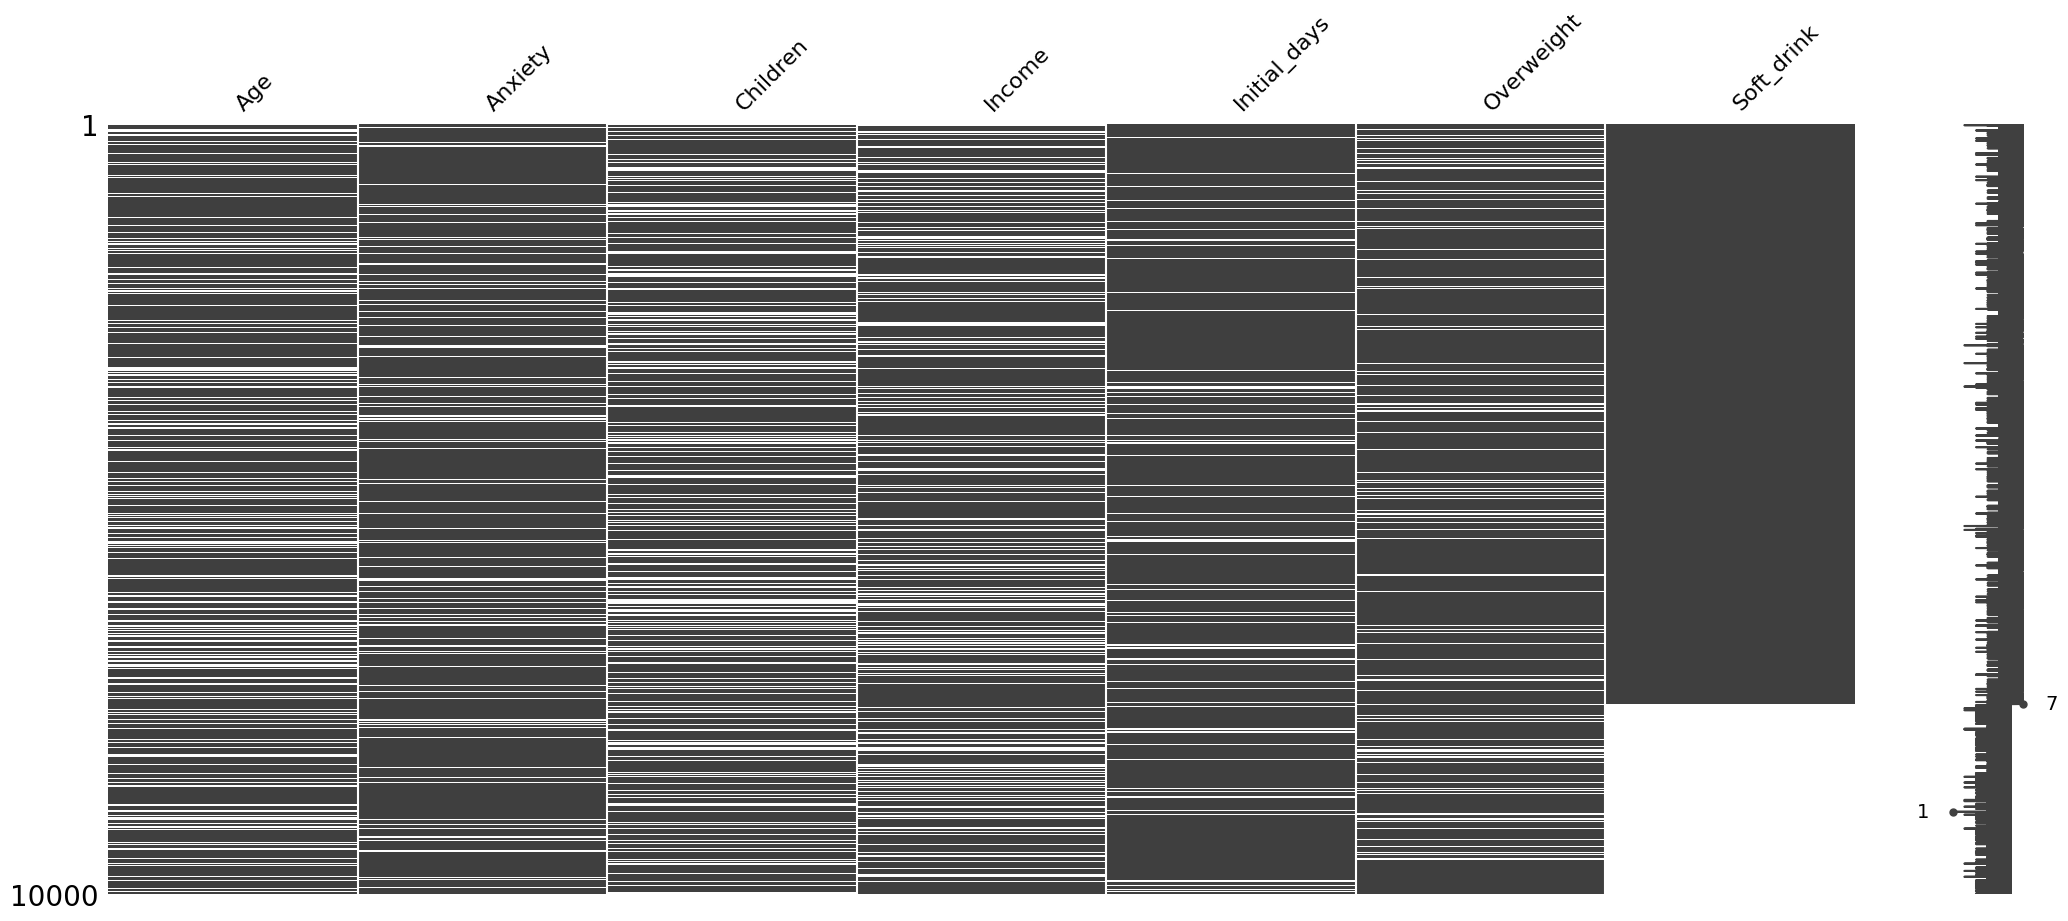

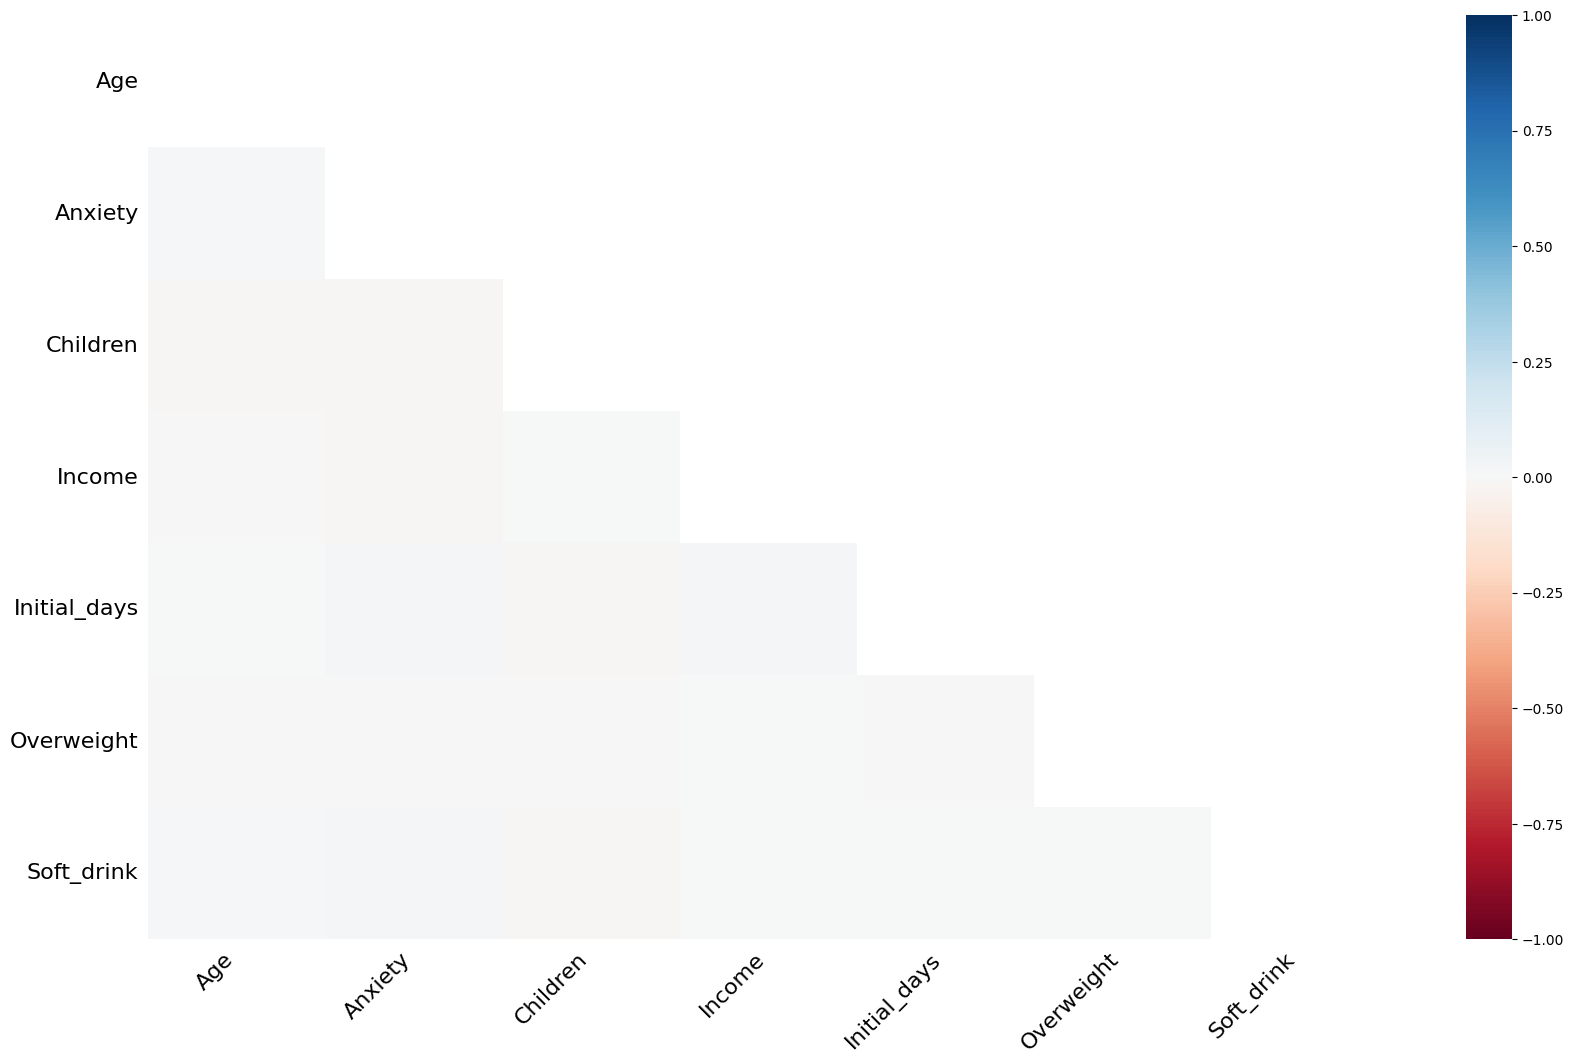

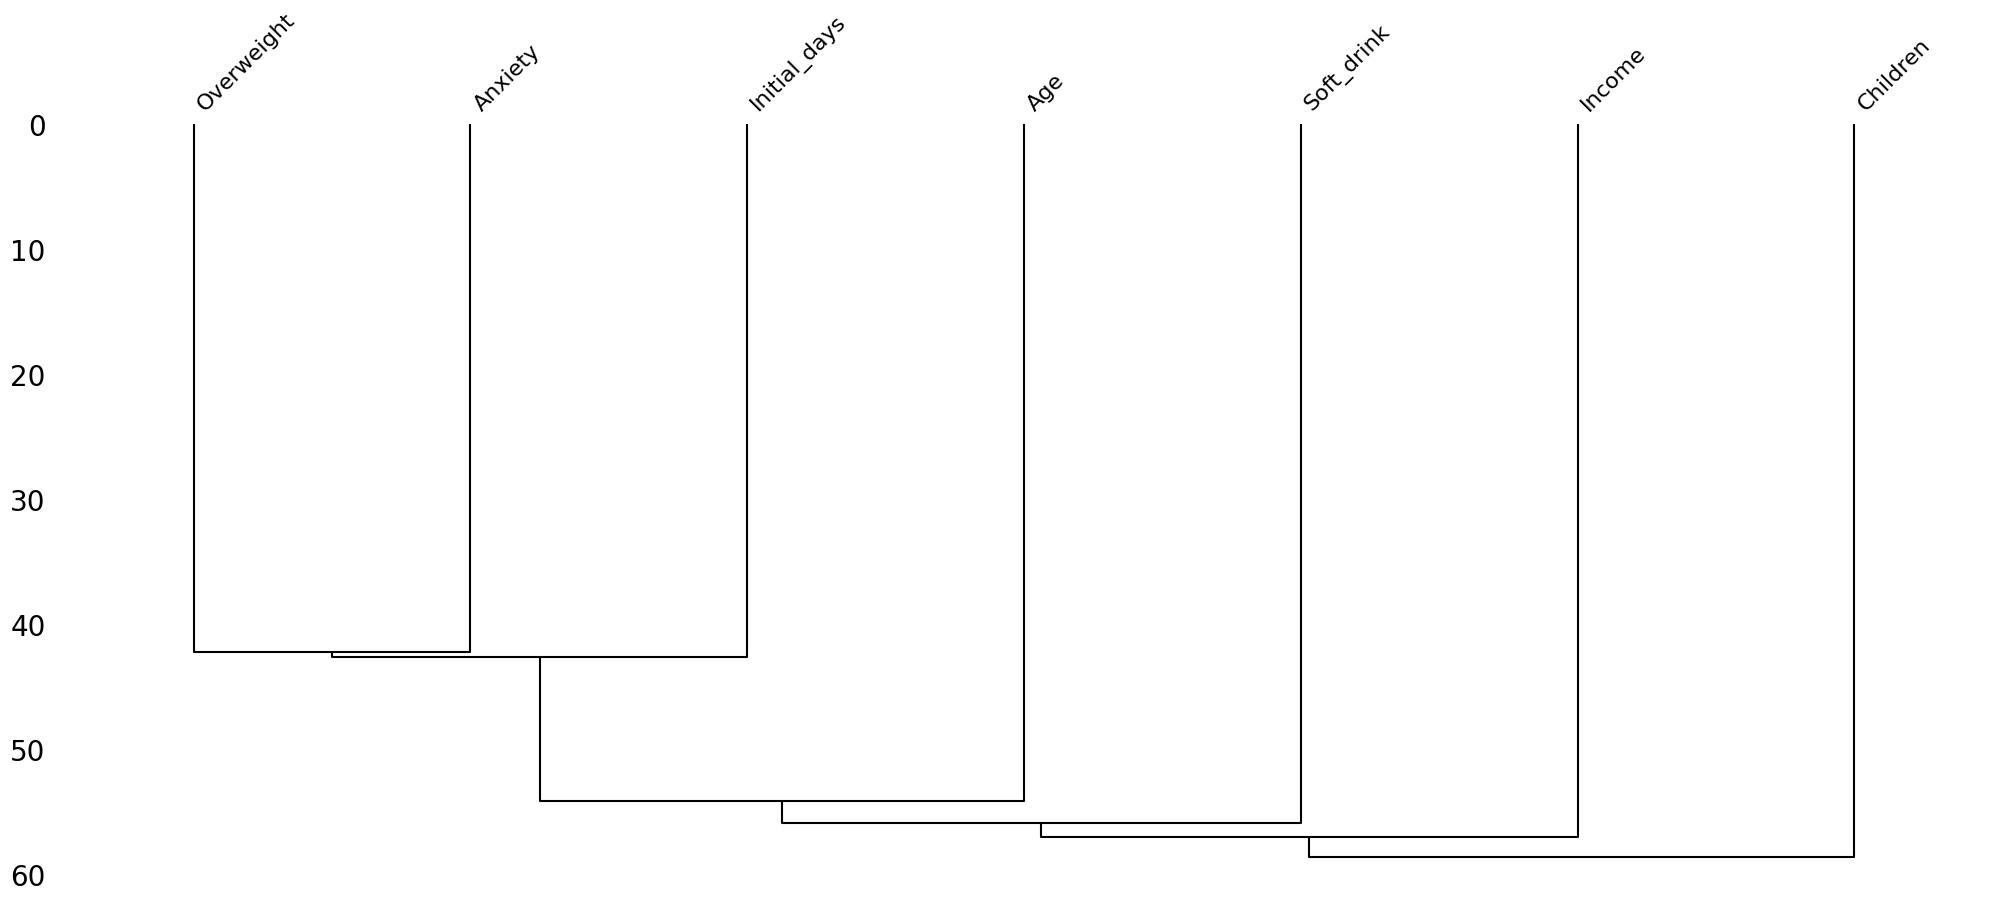

In [14]:
reduced = patients_df[variables_with_nulls].copy(deep=True)

for column in reduced.columns:
    sorted_df = reduced.sort_values(column)
    msno.matrix(sorted_df)

msno.heatmap(sorted_df)
msno.dendrogram(sorted_df)
plt.show()

Our graphical analysis strongly indicates there is little correlation between our missing values. It seems each is MCAR.

### Search for outliers

We will be searching *all* the quantitative variables except for `CaseOrder` for outliers. `CaseOrder` was generated as a way to be able to track the original order of the observations dataset and isn't truly a part of the data.

We start by making a list of the quantitative variables in the dataset.

In [15]:
quantitative_variables = [
    "Lat",
    "Lng",
    "Population",
    "Children",
    "Age",
    "Income",
    "VitD_levels",
    "Doc_visits",
    "Full_meals_eaten",
    "VitD_supp",
    "Initial_days",
    "TotalCharge",
    "Additional_charges",
    "Item1",
    "Item2",
    "Item3",
    "Item4",
    "Item5",
    "Item6",
    "Item7",
    "Item8",
]

 With our list of numeric variables in hand let us check them for outliers using scipy's `zscore()` method (scipy, n.d.).

In [16]:
quantitative_variables_df = patients_df[quantitative_variables]
z_scores = quantitative_variables_df.apply(zscore, axis=0, nan_policy="omit")

threshold = 3  # outliers = ּּ±3×σ

outliers = quantitative_variables_df[(z_scores > threshold) | (z_scores < -threshold)]

outliers_count = outliers.apply(lambda x: x.count(), axis=0)

print("Outliers Count:")
print(outliers_count)

Outliers Count:
Lat                   144
Lng                    98
Population            218
Children              146
Age                     0
Income                113
VitD_levels           500
Doc_visits              8
Full_meals_eaten       33
VitD_supp              70
Initial_days            0
TotalCharge           276
Additional_charges      0
Item1                  11
Item2                  12
Item3                  12
Item4                  12
Item5                  13
Item6                  10
Item7                  11
Item8                  12
dtype: int64


Let's take a look at the outliers graphically.

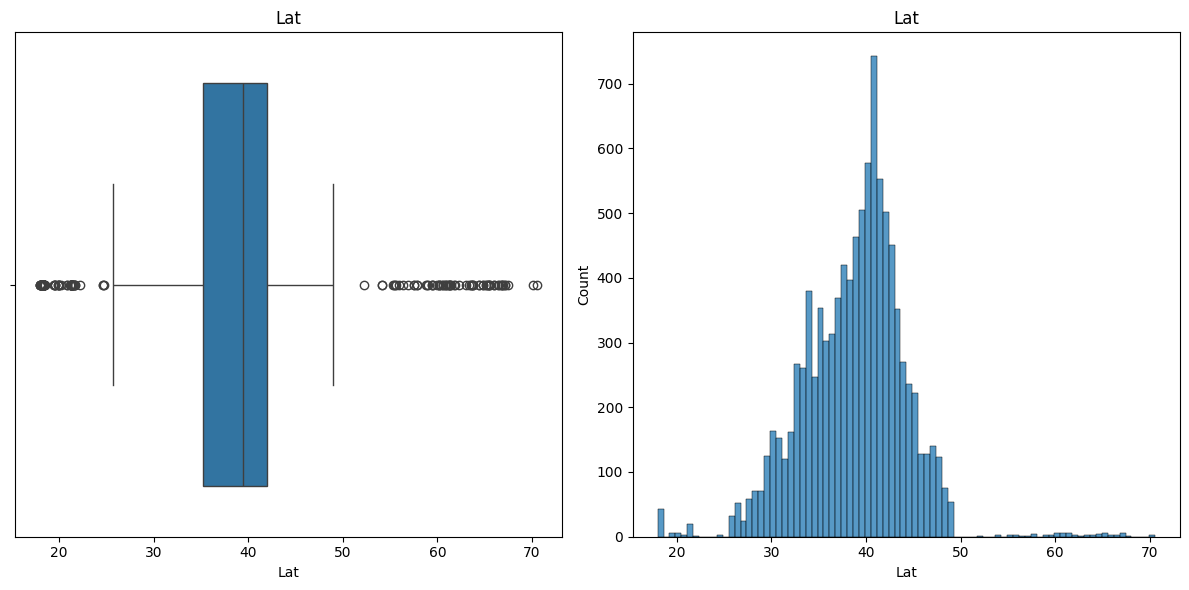

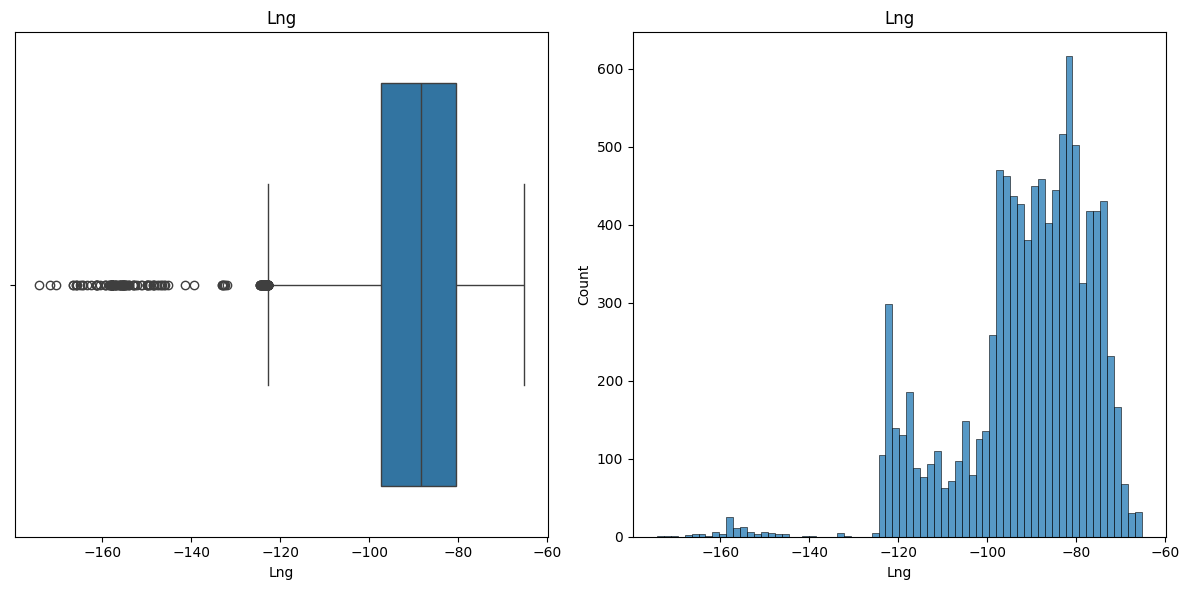

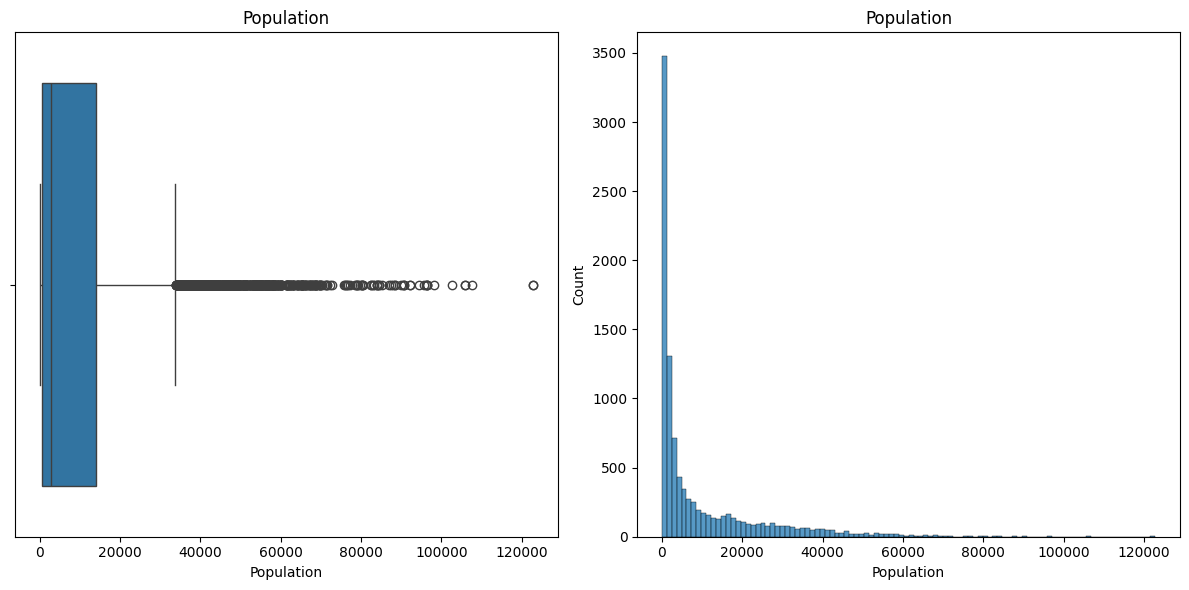

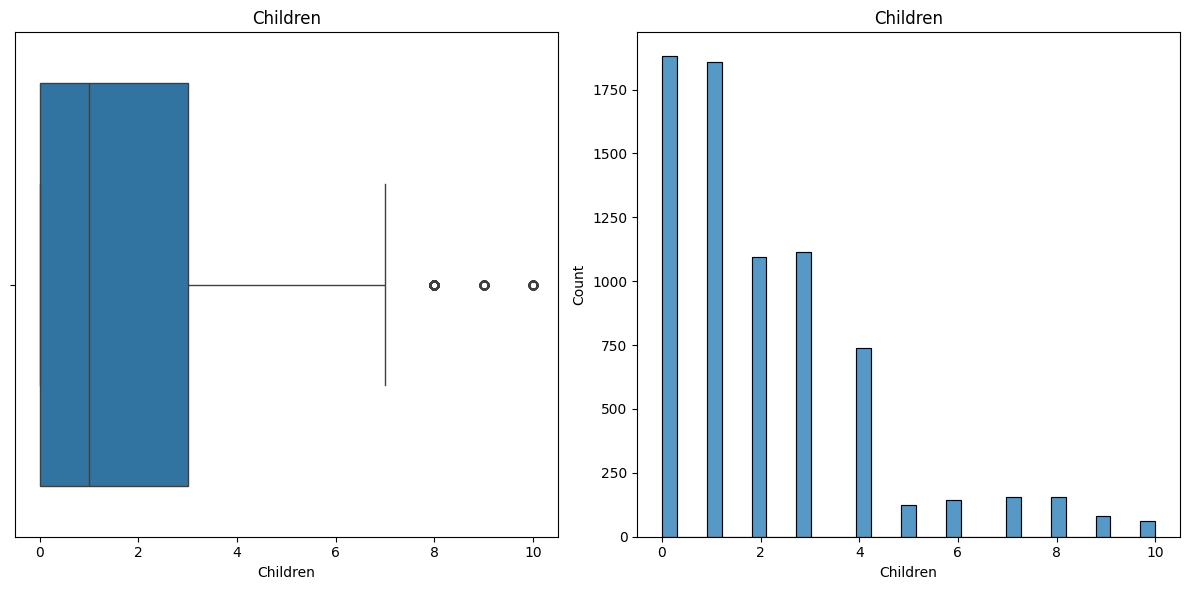

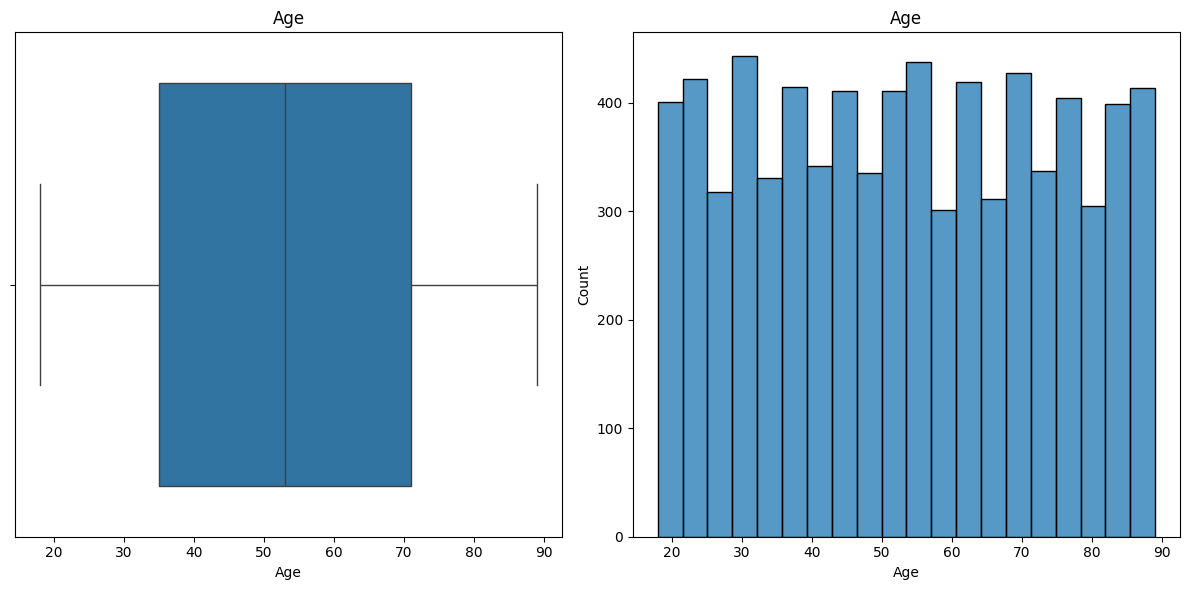

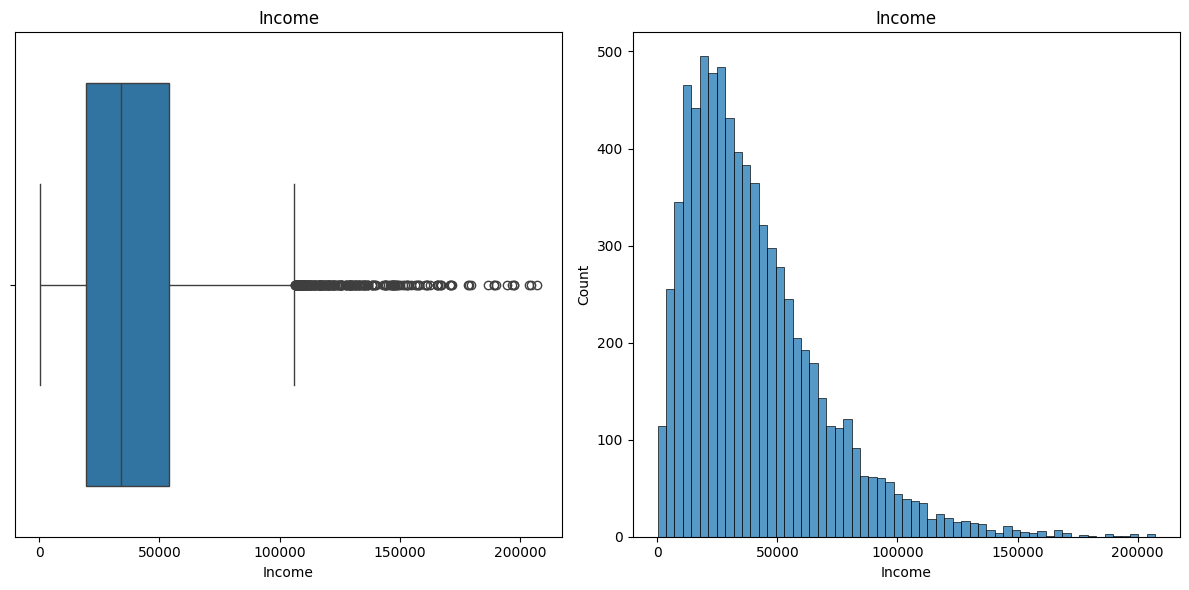

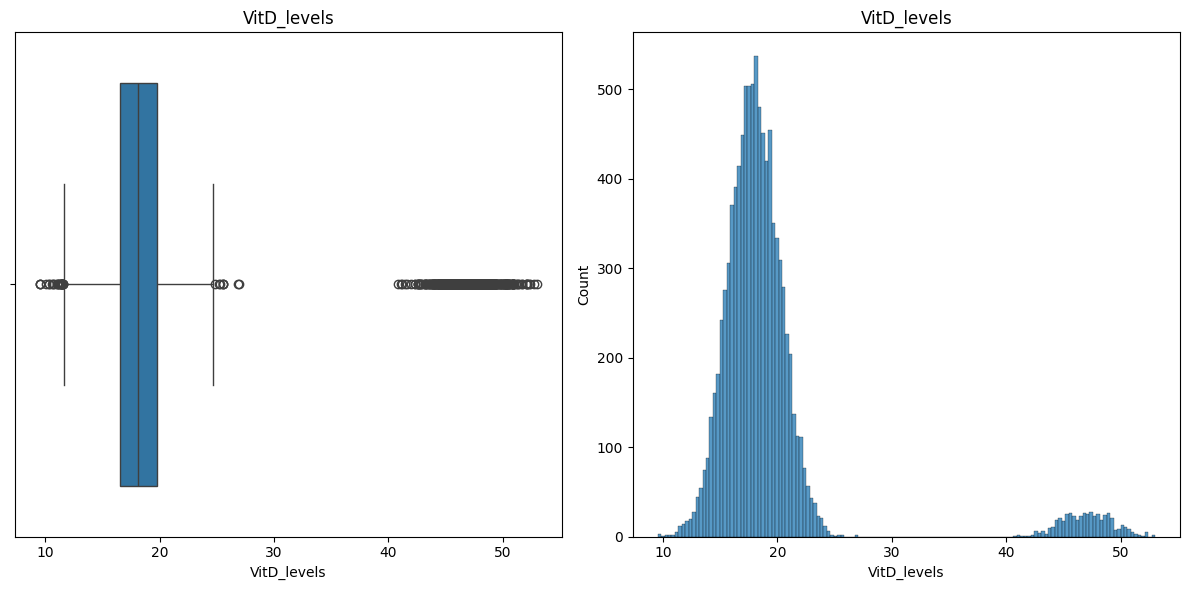

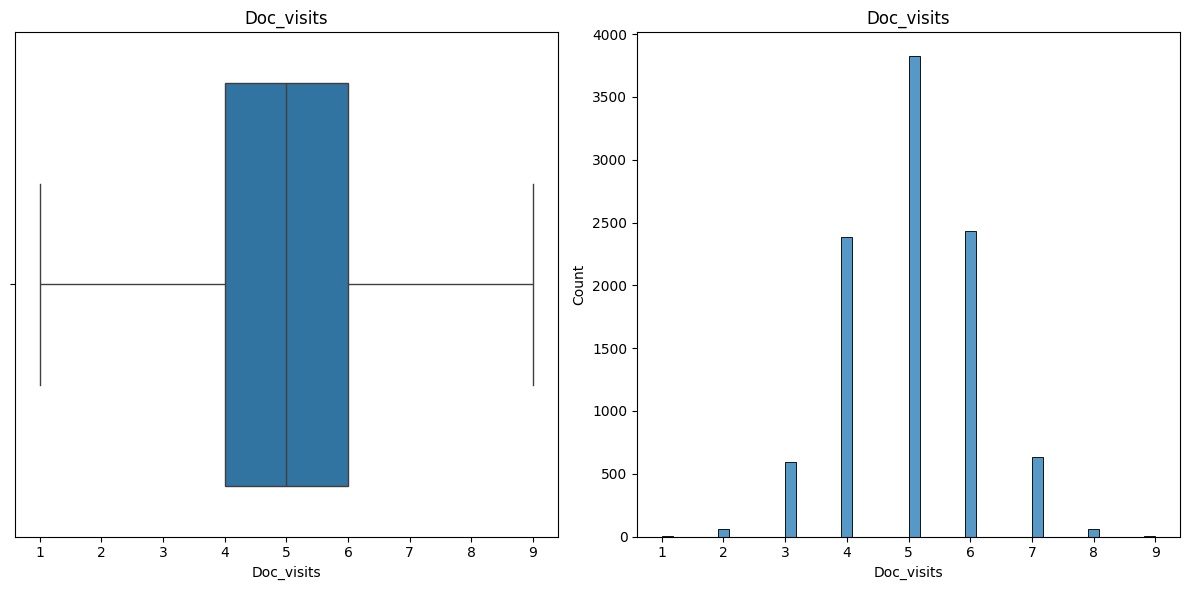

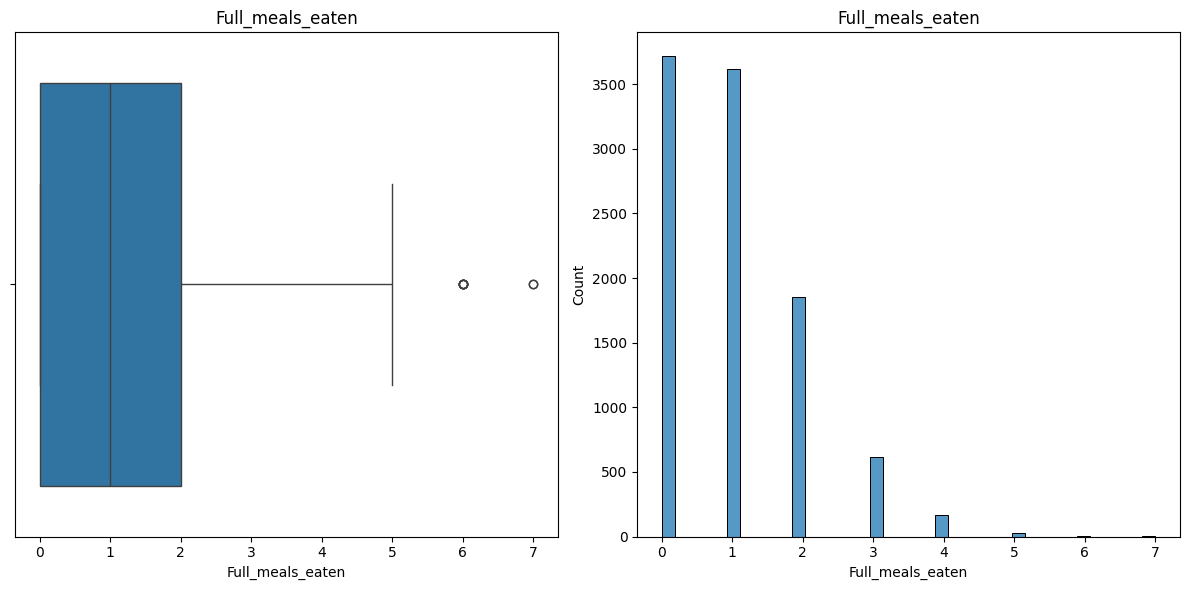

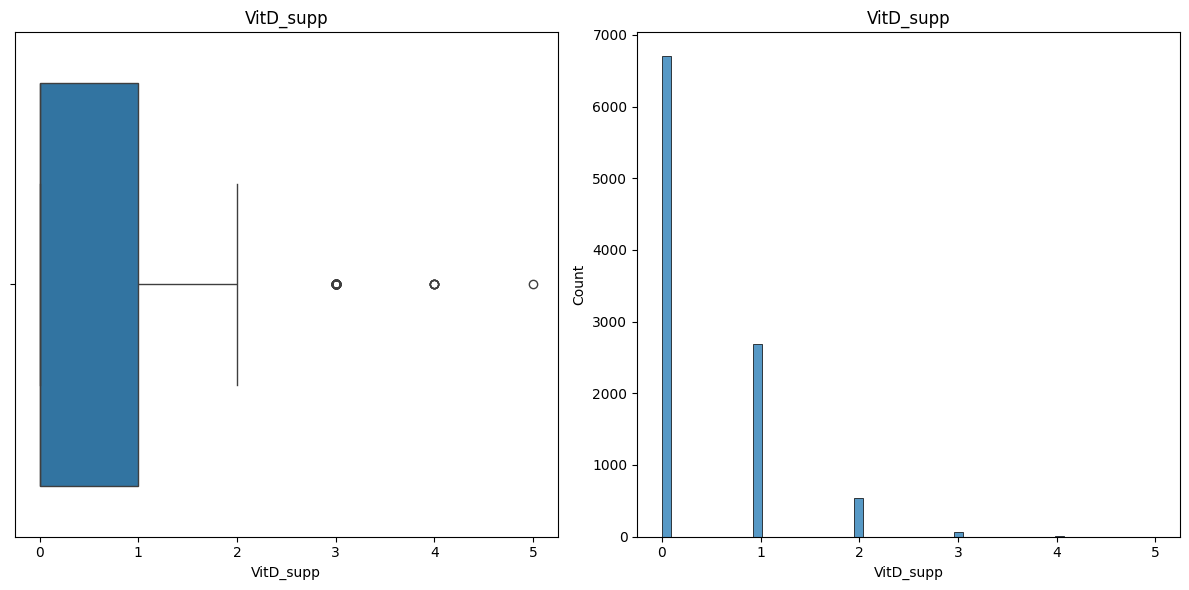

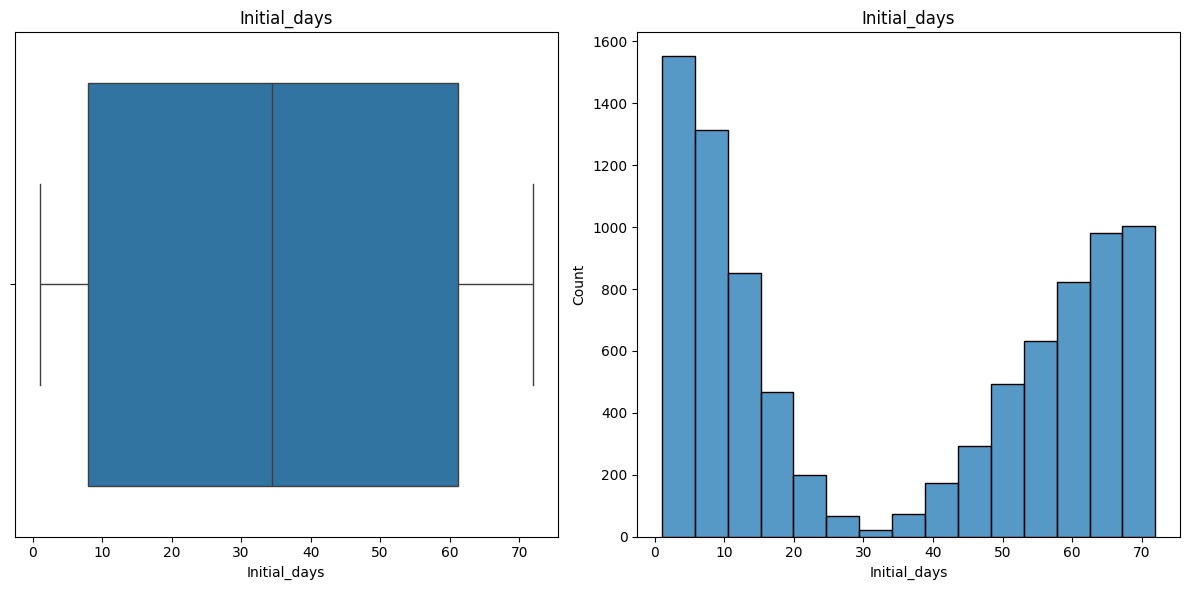

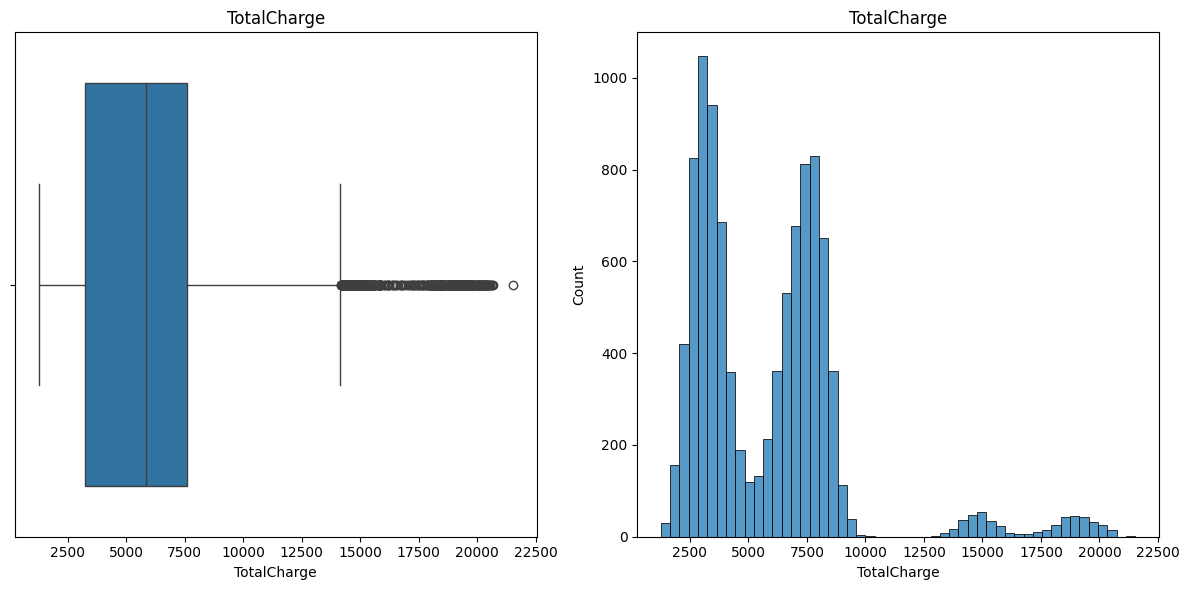

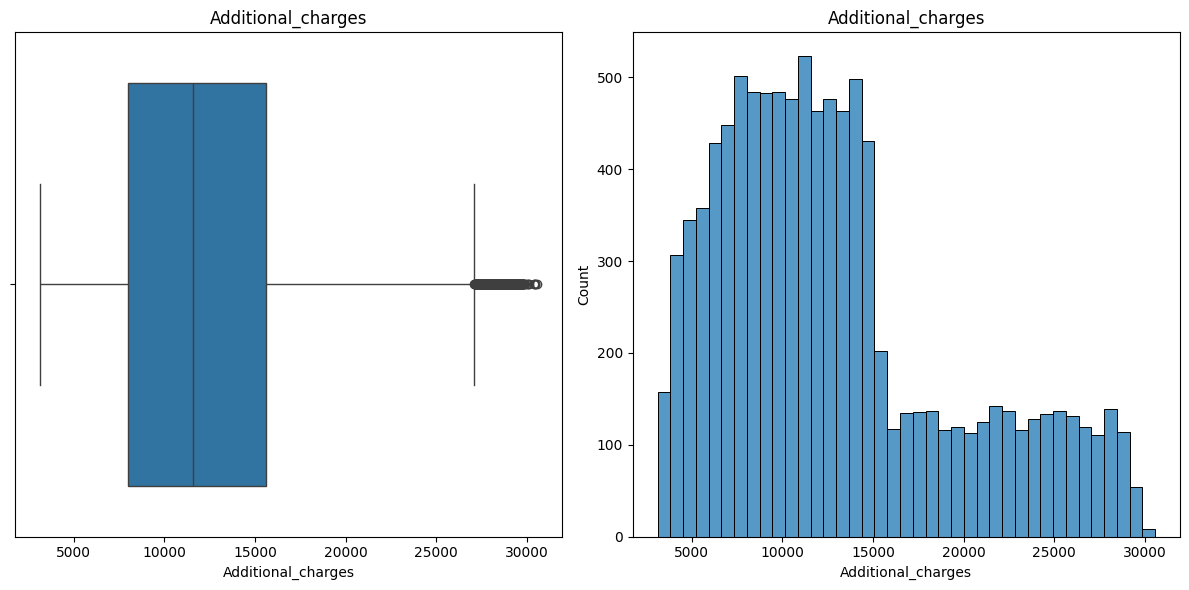

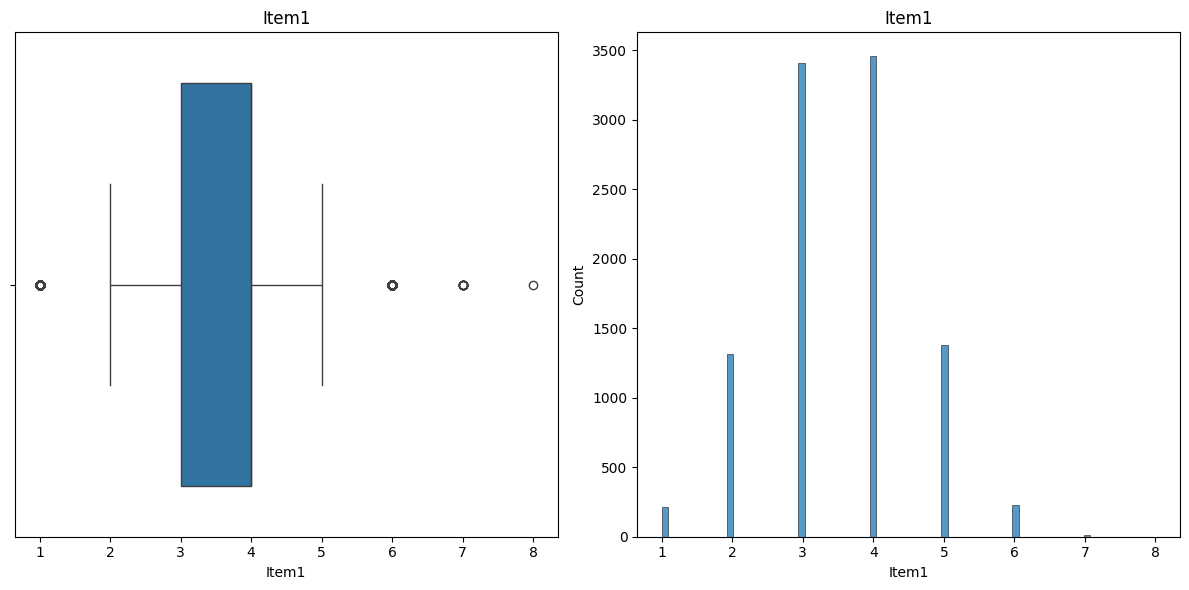

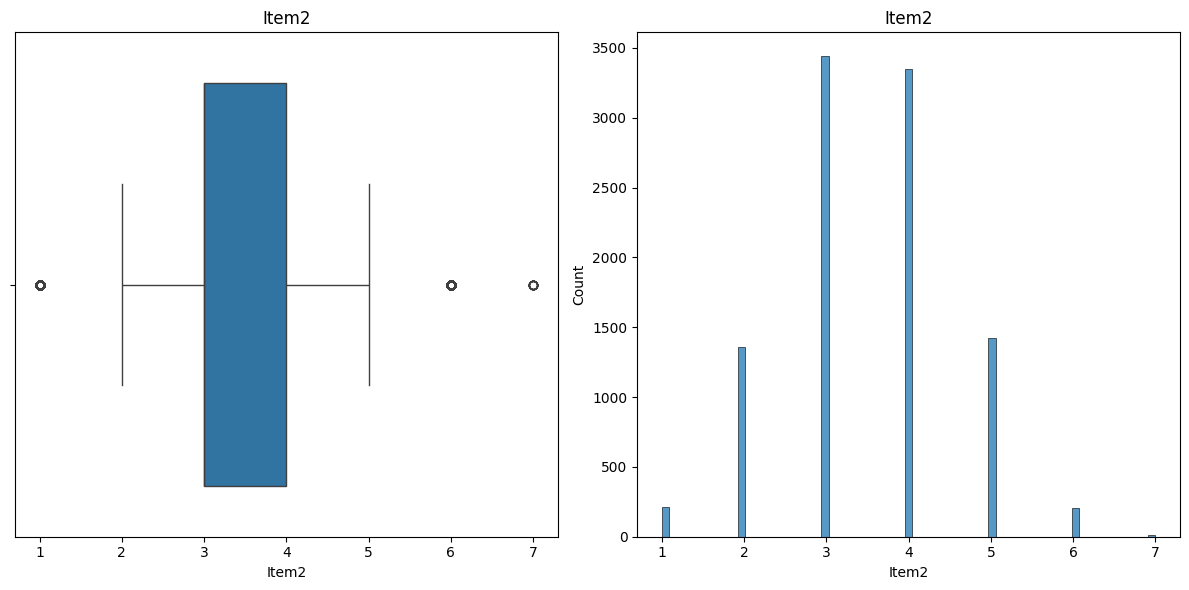

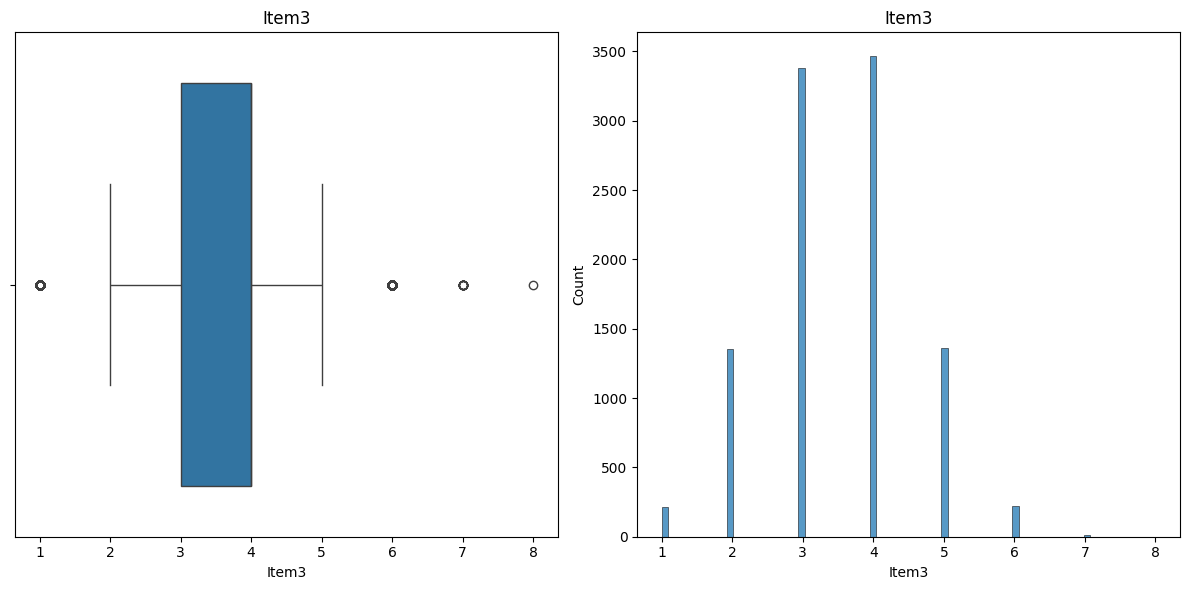

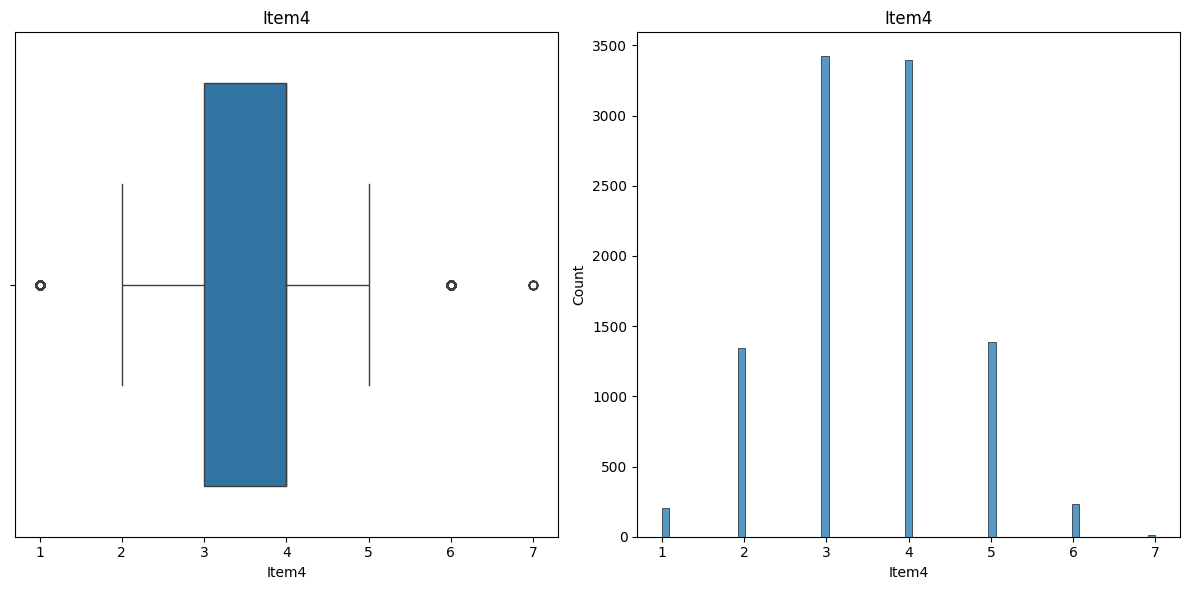

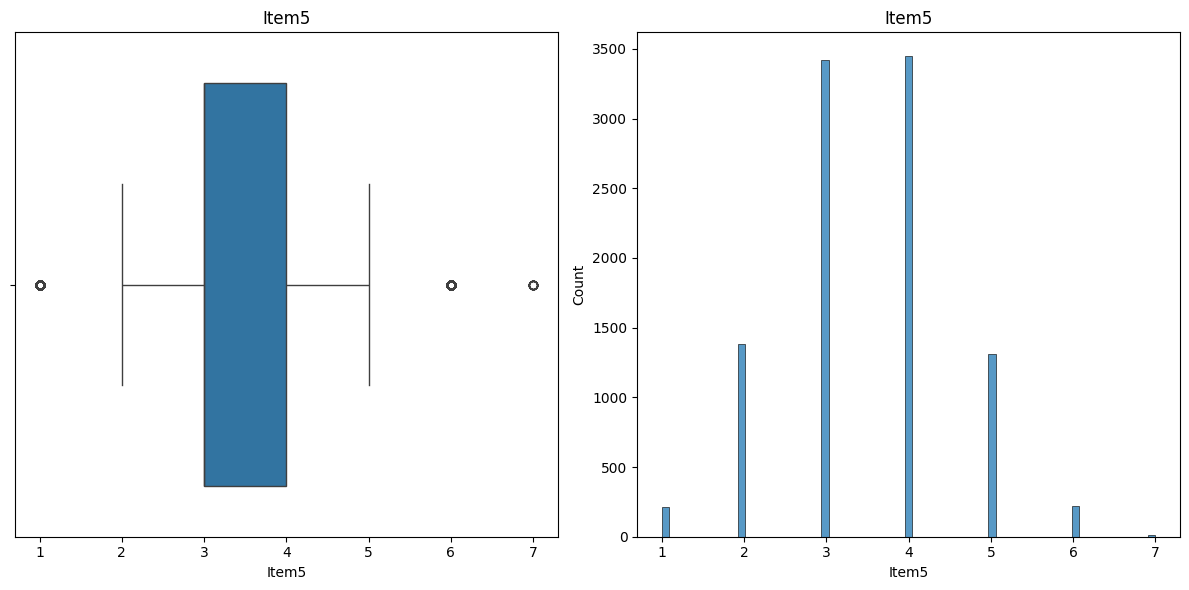

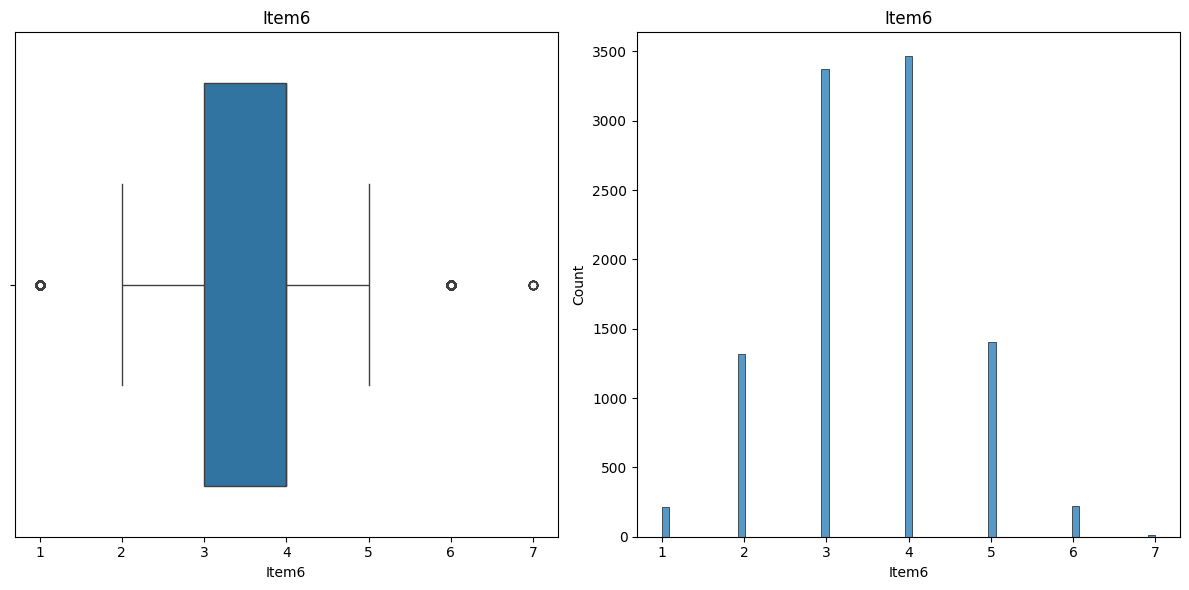

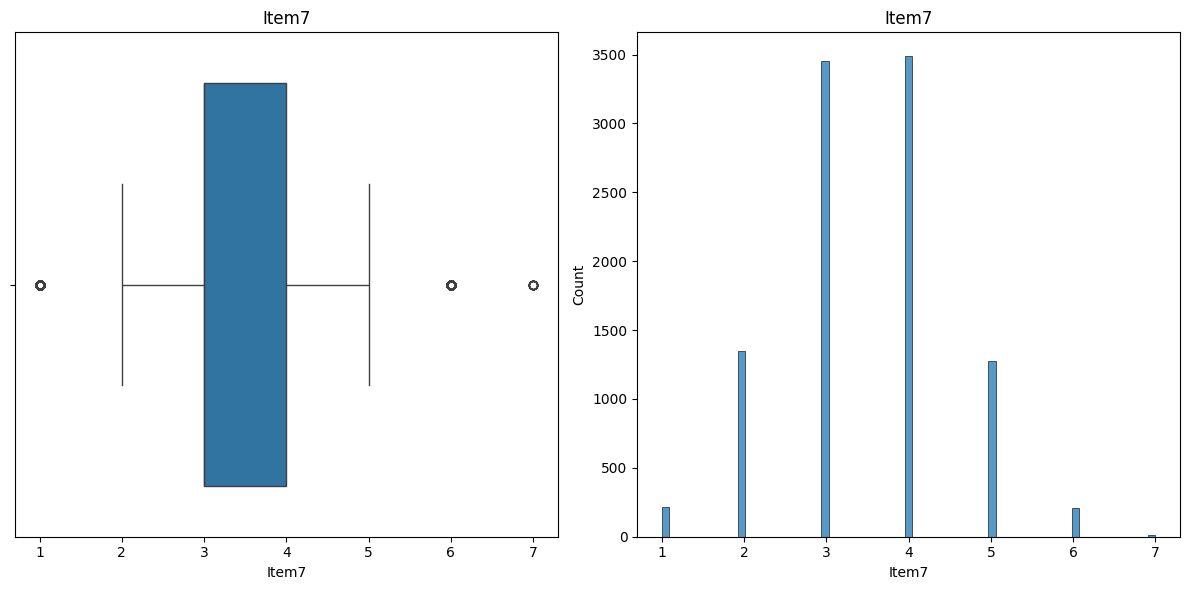

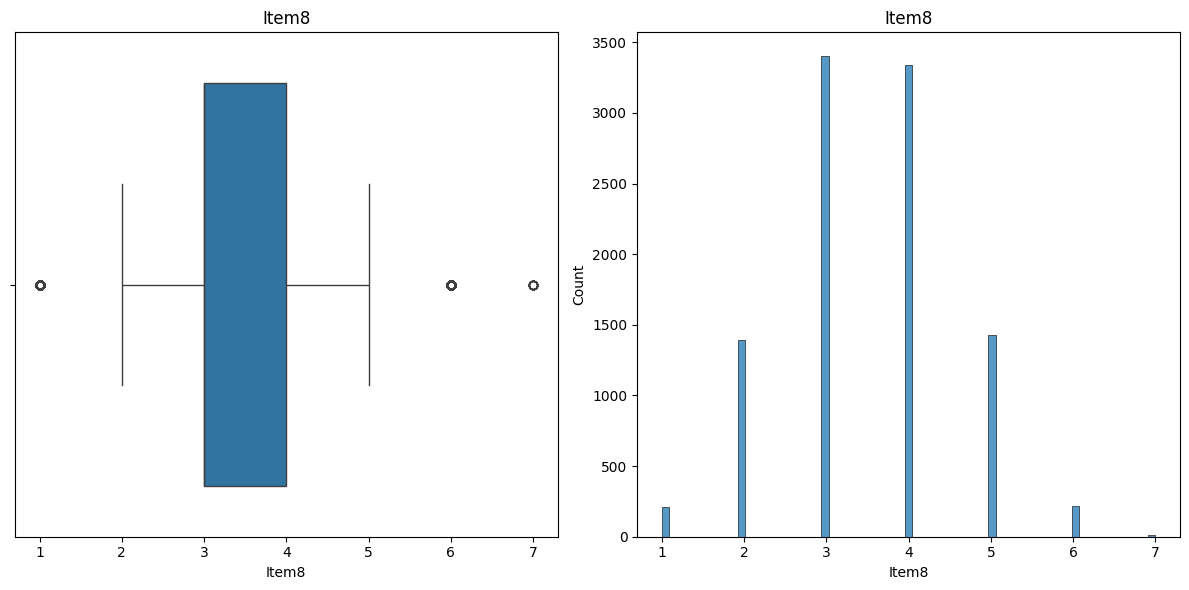

In [17]:
for variable in quantitative_variables_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.boxplot(x=quantitative_variables_df[variable], ax=axes[0])
    axes[0].set_title(variable)

    sns.histplot(quantitative_variables_df[variable], ax=axes[1])
    axes[1].set_title(variable)

    plt.tight_layout()
    plt.show()

## D2: Treatment

### Treating duplicate data

Our exploration of the data found no duplicates.

### Treating missing data

There are many missing values that need to be dealt with. Let us get a feel for their distributions.

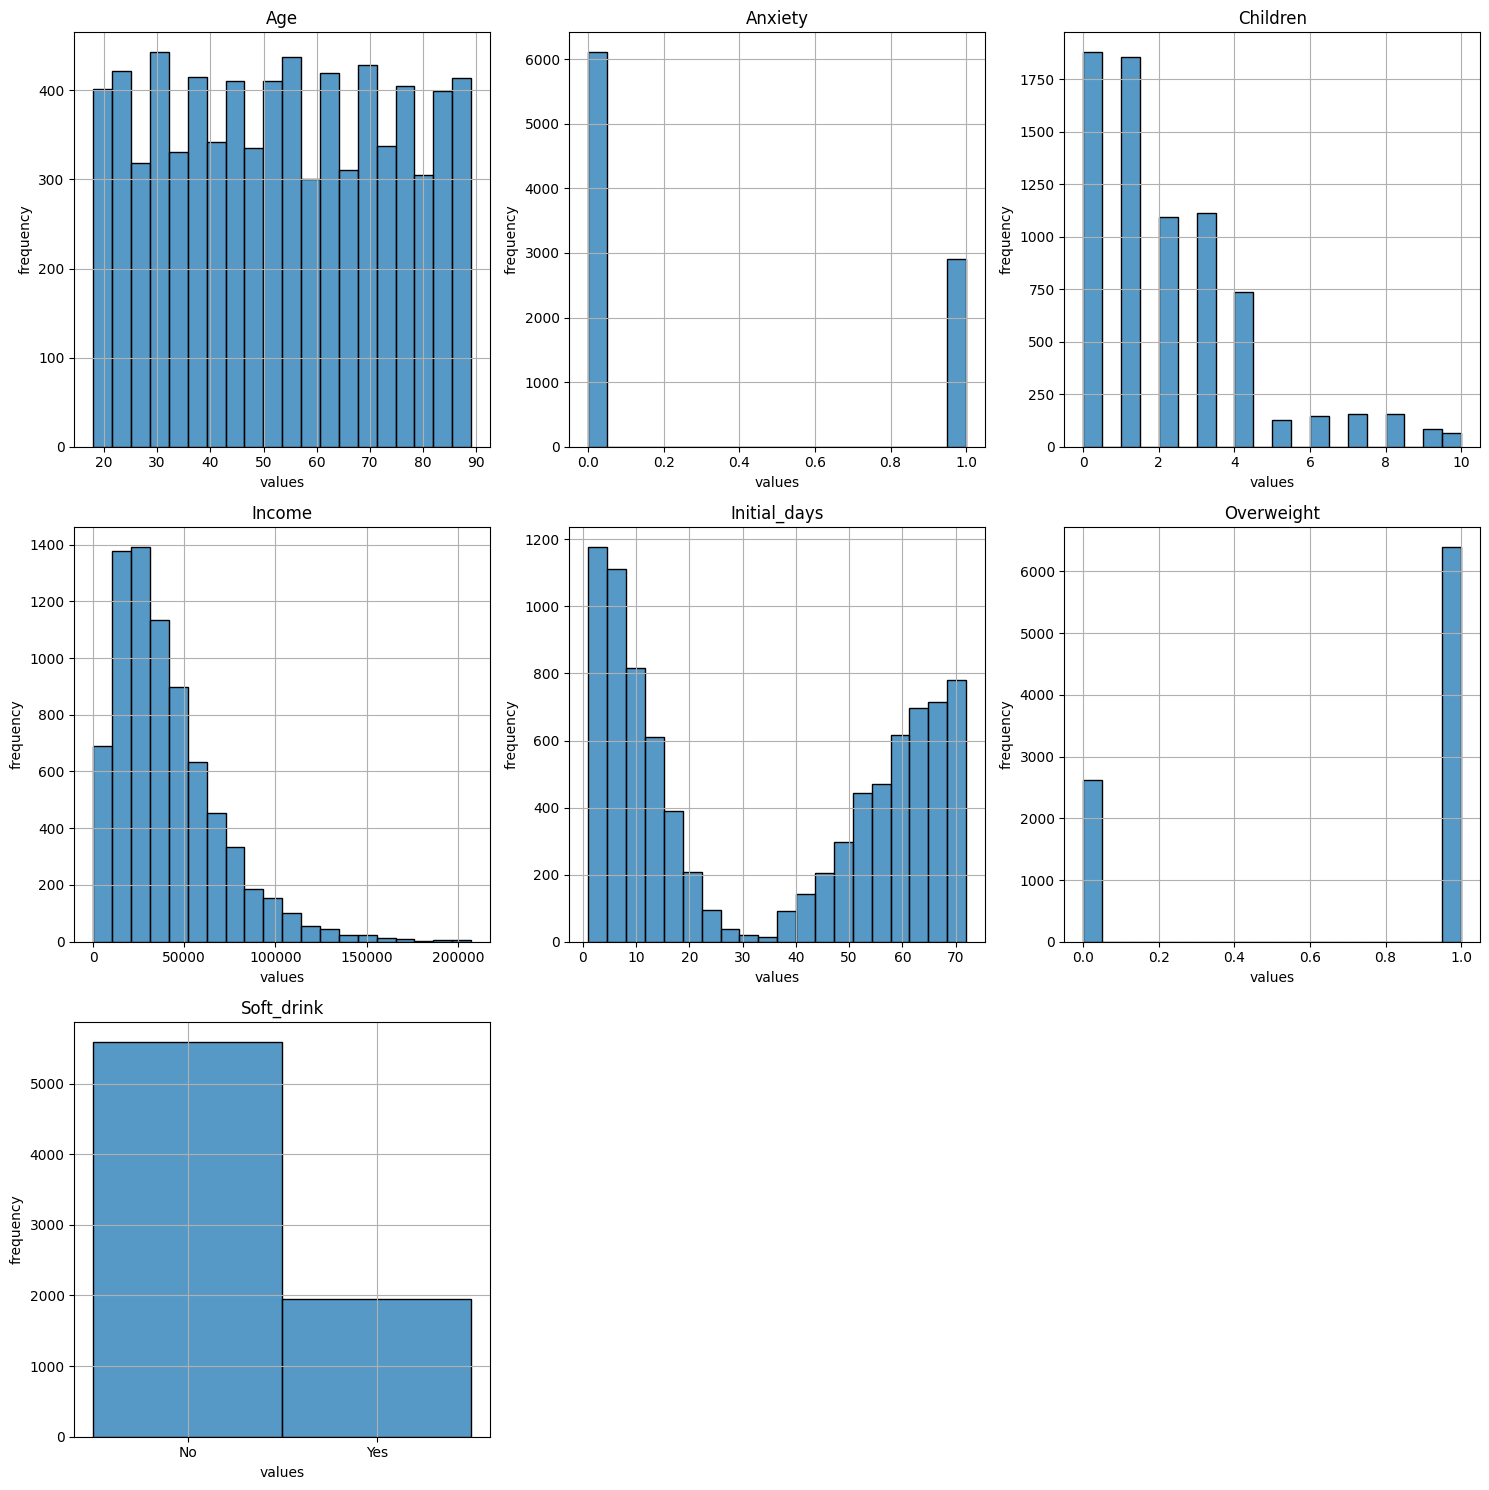

In [18]:
num_cols = len(reduced.columns)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

axes = axes.flatten()

for i, column in enumerate(reduced.columns):
    sns.histplot(reduced[column], bins=20, ax=axes[i])
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel("values")
    axes[i].set_ylabel("frequency")
    axes[i].grid(True)

for j in range(num_cols, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Seeing the distributions of the data we can now choose imputation techniques appropriate to each variable. 

`Age`, `Children` and `Income` will be treated using univariate statistical imputation and replacing missing values with the median. `Anxiety` and `Overweight` will be imputed using a `SimpleImputer`. `Initial_days` and `Soft_drink` will be treated using K-Nearest Neighbor (KNN). Because of some of the data is categorical we will need to temporarily encode it numerically so the KNN can impute the missing values.

We'll begin by making a copy of the data to treat. This will allow us to do a before-and-after comparison later.

In [19]:
patients_treated_df = patients_df.copy(deep=True)

And now the missing values can be imputed.

`Age`, `Children`, and `Income` will be treated by replacing missing values with the median of the variable.

In [20]:
# the code below throws a warning about changes coming to pandas in v3.0, rewrite as shown
# patients_treated_df["Children"].fillna(patients_treated_df["Children"].median(), inplace=True)
patients_treated_df.fillna({"Age": patients_treated_df["Age"].median()}, inplace=True)
patients_treated_df.fillna({"Children": patients_treated_df["Children"].median()}, inplace=True)
patients_treated_df.fillna({"Income": patients_treated_df["Income"].median()}, inplace=True)

`Soft_drink` contains yes/no responses (and missing values). We'll use KNN to impute it after mapping the text responses to numbers and ultimately back again.

In [21]:
knn_imputer = KNN()

patients_treated_df["Soft_drink"] = patients_treated_df["Soft_drink"].map({"Yes": 1, "No": 0})
patients_treated_df["Soft_drink"] = knn_imputer.fit_transform(patients_treated_df[["Soft_drink"]])
patients_treated_df["Soft_drink"] = patients_treated_df["Soft_drink"].map({1: "Yes", 0: "No"})

Imputing row 1/10000 with 1 missing, elapsed time: 16.252
Imputing row 101/10000 with 1 missing, elapsed time: 16.253
Imputing row 201/10000 with 0 missing, elapsed time: 16.257
Imputing row 301/10000 with 0 missing, elapsed time: 16.258
Imputing row 401/10000 with 1 missing, elapsed time: 16.259
Imputing row 501/10000 with 0 missing, elapsed time: 16.260
Imputing row 601/10000 with 0 missing, elapsed time: 16.261
Imputing row 701/10000 with 0 missing, elapsed time: 16.262
Imputing row 801/10000 with 0 missing, elapsed time: 16.263
Imputing row 901/10000 with 0 missing, elapsed time: 16.272
Imputing row 1001/10000 with 0 missing, elapsed time: 16.274
Imputing row 1101/10000 with 0 missing, elapsed time: 16.275
Imputing row 1201/10000 with 1 missing, elapsed time: 16.276
Imputing row 1301/10000 with 1 missing, elapsed time: 16.277
Imputing row 1401/10000 with 0 missing, elapsed time: 16.277
Imputing row 1501/10000 with 1 missing, elapsed time: 16.278
Imputing row 1601/10000 with 0 missi

`Anxiety` and `Overweight` contain 0/1 responses (and missing values). We'll use a `SimpleImputer` to impute the values.

In [22]:
simple_imputer = SimpleImputer(strategy="most_frequent")

anxiety_imputed = simple_imputer.fit_transform(patients_treated_df[["Anxiety"]]).astype("int")
patients_treated_df["Anxiety"] = anxiety_imputed

overweight_imputed = simple_imputer.fit_transform(patients_treated_df[["Overweight"]]).astype("int")
patients_treated_df["Overweight"] = overweight_imputed

The remaining variables will be treated using KNN.

In [23]:
columns_to_encode_and_impute = [
    "Age",
    "Allergic_rhinitis",
    "Area",
    "Arthritis",
    "Asthma",
    "BackPain",
    "Complication_risk",
    "Diabetes",
    "Education",
    "Employment",
    "Gender",
    "HighBlood",
    "Hyperlipidemia",
    "Initial_admin",
    "Initial_days",
    "Job",
    "Marital",
    "ReAdmis",
    "Reflux_esophagitis",
    "Stroke",
    "Timezone",
]

columns_to_encode = [
    "Age",
    "Allergic_rhinitis",
    "Area",
    "Arthritis",
    "Asthma",
    "BackPain",
    "Complication_risk",
    "Diabetes",
    "Education",
    "Employment",
    "Gender",
    "HighBlood",
    "Hyperlipidemia",
    "Initial_admin",
    "Job",
    "Marital",
    "ReAdmis",
    "Reflux_esophagitis",
    "Stroke",
    "Timezone",
    "Anxiety",
]

columns_to_impute = ["Initial_days"]

encoder = OrdinalEncoder()
patients_treated_df[columns_to_encode] = encoder.fit_transform(patients_treated_df[columns_to_encode].astype(str))

imputer = KNN()
patients_treated_df[columns_to_impute] = imputer.fit_transform(patients_treated_df[columns_to_impute])

patients_treated_df[columns_to_encode] = encoder.inverse_transform(patients_treated_df[columns_to_encode].astype(int))

Imputing row 1/10000 with 0 missing, elapsed time: 18.935
Imputing row 101/10000 with 0 missing, elapsed time: 18.936
Imputing row 201/10000 with 0 missing, elapsed time: 18.936
Imputing row 301/10000 with 0 missing, elapsed time: 18.937
Imputing row 401/10000 with 0 missing, elapsed time: 18.937
Imputing row 501/10000 with 0 missing, elapsed time: 18.938
Imputing row 601/10000 with 1 missing, elapsed time: 18.939
Imputing row 701/10000 with 0 missing, elapsed time: 18.944
Imputing row 801/10000 with 0 missing, elapsed time: 18.945
Imputing row 901/10000 with 0 missing, elapsed time: 18.946
Imputing row 1001/10000 with 0 missing, elapsed time: 18.947
Imputing row 1101/10000 with 0 missing, elapsed time: 18.948
Imputing row 1201/10000 with 1 missing, elapsed time: 18.948
Imputing row 1301/10000 with 0 missing, elapsed time: 18.950
Imputing row 1401/10000 with 1 missing, elapsed time: 18.951
Imputing row 1501/10000 with 0 missing, elapsed time: 18.951
Imputing row 1601/10000 with 0 missi

In [24]:
patients_treated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  Timezone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  float64
 15  Age                 10000 non-null  object 
 16  Education

### Treating outliers

The only variable with values that were out of range is latitude (`Lat`) which for the United States should range between 18.9100° N to 49.3844° N (OpenAI, 2024). To correct this, set any `Lat` value less than 18.9100 to 18.9 and any value greater than 49.3844 to 49.4.

In [25]:
lat_min = 18.9131
lat_max = 49.3844

patients_treated_df["Lat"] = np.where(patients_treated_df["Lat"] < lat_min, lat_min, patients_treated_df["Lat"])
patients_treated_df["Lat"] = np.where(patients_treated_df["Lat"] > lat_max, lat_max, patients_treated_df["Lat"])

### Re-expressing categorical variables

The `OrdinalEncoder` returns a DataFrame with an index that starts at 0. Because our `CaseOrder` variable starts at 1 we might see a misalignment between the DataFrames that results in the newly re-encoded variables having one less value than the originals. We fix this with:

```python
reencoded_df.index = patients_treated_df.index
```

In [26]:
categorical_variables = [
    "Allergic_rhinitis",
    "Area",
    "Arthritis",
    "Asthma",
    "BackPain",
    "Complication_risk",
    "Diabetes",
    "Education",
    "Employment",
    "Gender",
    "HighBlood",
    "Hyperlipidemia",
    "Initial_admin",
    "Job",
    "Marital",
    "ReAdmis",
    "Reflux_esophagitis",
    "Services",
    "Soft_drink",
    "Stroke",
    "Timezone",
]

encoder = OrdinalEncoder()

reencoded_df = pd.DataFrame()
reencoded_df[categorical_variables] = encoder.fit_transform(patients_treated_df[categorical_variables])

reencoded_df.index = patients_treated_df.index

for variable in categorical_variables:
    patients_treated_df[variable + "_num"] = reencoded_df[variable]

print(patients_treated_df.shape)
print(patients_treated_df.info())

(10000, 73)
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CaseOrder               10000 non-null  int64  
 1   Customer_id             10000 non-null  object 
 2   Interaction             10000 non-null  object 
 3   UID                     10000 non-null  object 
 4   City                    10000 non-null  object 
 5   State                   10000 non-null  object 
 6   County                  10000 non-null  object 
 7   Zip                     10000 non-null  int64  
 8   Lat                     10000 non-null  float64
 9   Lng                     10000 non-null  float64
 10  Population              10000 non-null  int64  
 11  Area                    10000 non-null  object 
 12  Timezone                10000 non-null  object 
 13  Job                     10000 non-null  object 
 14  Children                10000 n

### Misc treatments

Let's perform a little miscellaneous clean-up.

In [27]:
patients_treated_df["Children"] = patients_treated_df["Children"].astype(int)
patients_treated_df["Doc_visits"] = patients_treated_df["Doc_visits"].astype(int)
patients_treated_df["Full_meals_eaten"] = patients_treated_df["Full_meals_eaten"].astype(int)

patients_treated_df["Income"] = patients_treated_df["Income"].round(decimals=2)
patients_treated_df["TotalCharge"] = patients_treated_df["TotalCharge"].round(decimals=2)
patients_treated_df["Additional_charges"] = patients_treated_df["Additional_charges"].round(decimals=2)

patients_treated_df["Age"] = patients_treated_df["Age"].round(decimals=0).astype(float)

patients_treated_df["VitD_levels"] = patients_treated_df["VitD_levels"].round(decimals=2)
patients_treated_df["Initial_days"] = patients_treated_df["Initial_days"].round(decimals=1)

patients_treated_df.rename(
    columns={
        "Item1": "Question1",
        "Item2": "Question2",
        "Item3": "Question3",
        "Item4": "Question4",
        "Item5": "Question5",
        "Item6": "Question6",
        "Item7": "Question7",
        "Item8": "Question8",
    },
    inplace=True,
)

## D3: Work performed

### Missing values 

We can observe the count of missing values was 0 post-treatment.

In [28]:
print("Pre-treatment:")
print(patients_df.info())
print()
print("Pre-treatment:")
print(patients_treated_df.info())

Pre-treatment:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  Timezone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            7412 non-null   float64
 15  Age                 7586 non-null   float64

In [29]:
print(f"Missing values pre-treatment: {patients_df.isna().sum().sum()}")
print(f"Missing values post-treatment: {patients_treated_df.isna().sum().sum()}")

Missing values pre-treatment: 12955
Missing values post-treatment: 0


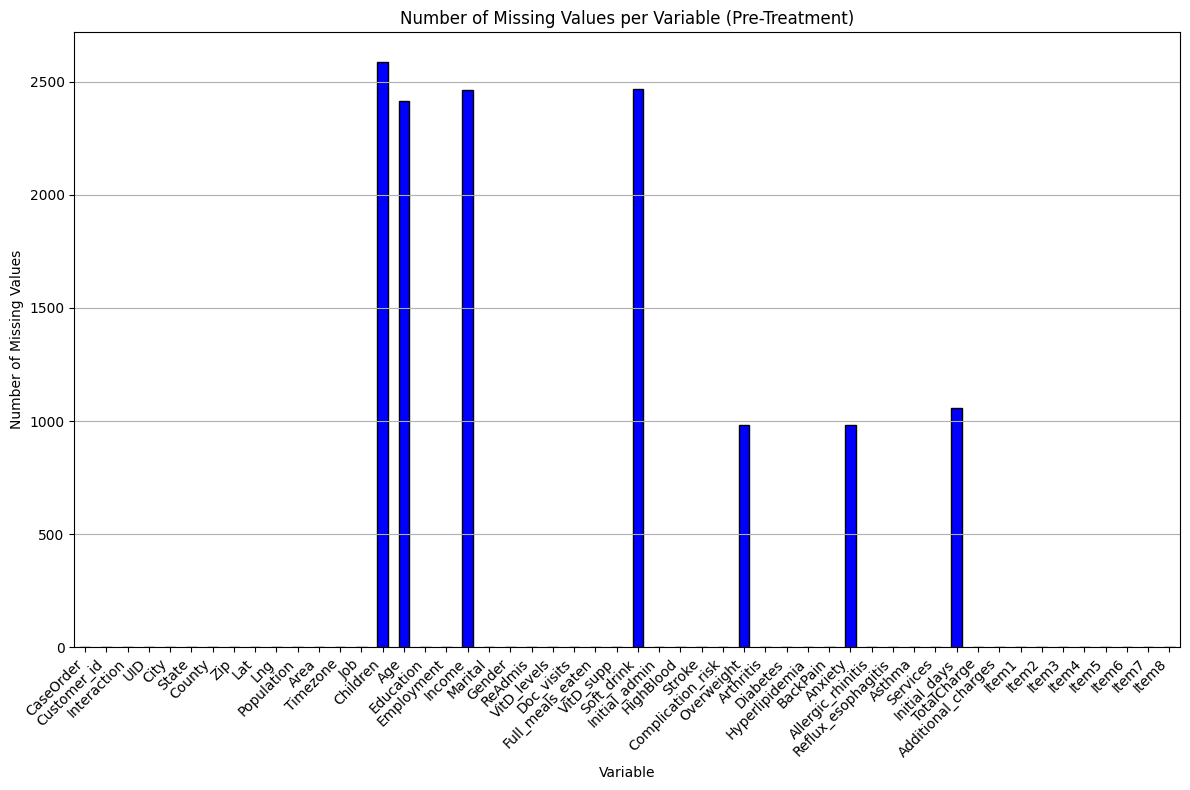

In [30]:
missing_values_count = patients_df.isnull().sum()

plt.figure(figsize=(12, 8))
missing_values_count.plot(kind="bar", color="blue", edgecolor="black")
plt.title("Number of Missing Values per Variable (Pre-Treatment)")
plt.xlabel("Variable")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

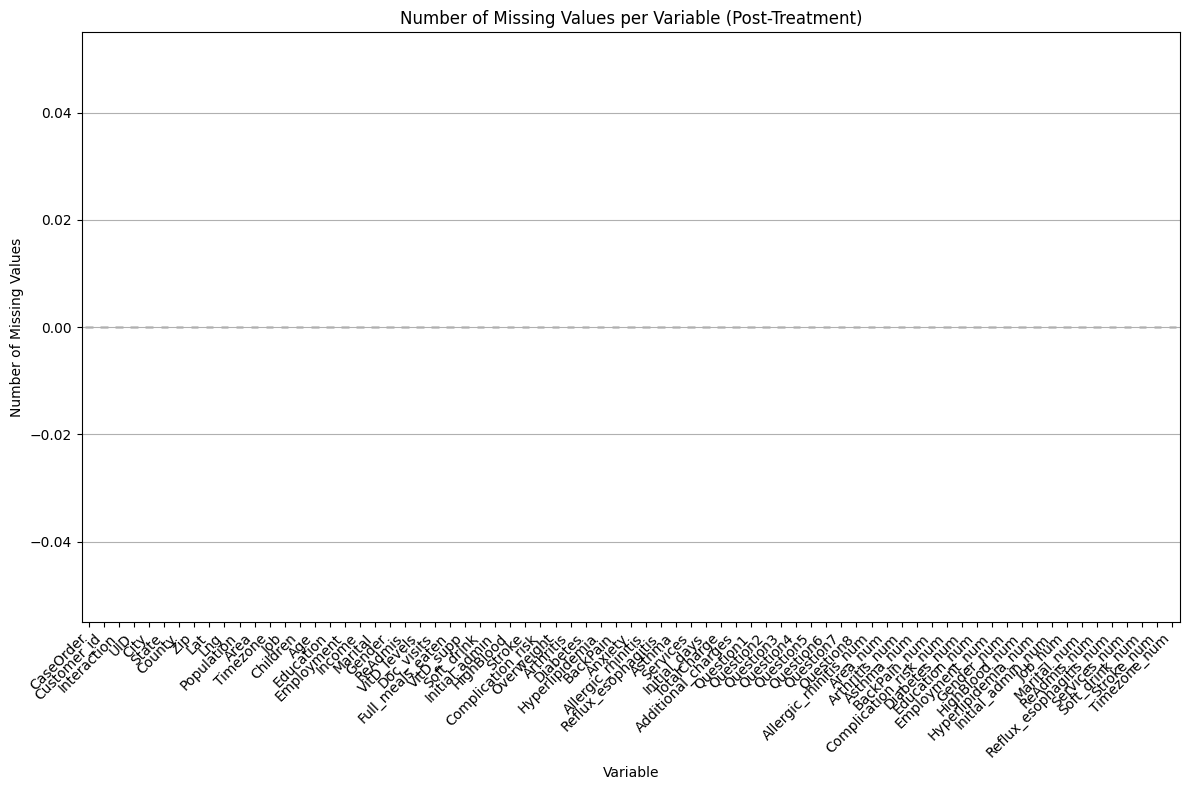

In [31]:
missing_values_count = patients_treated_df.isnull().sum()

plt.figure(figsize=(12, 8))
missing_values_count.plot(kind="bar", color="blue", edgecolor="black")
plt.title("Number of Missing Values per Variable (Post-Treatment)")
plt.xlabel("Variable")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

We can also see that the distribution of values in the variables that previously had missing values has remained stable.

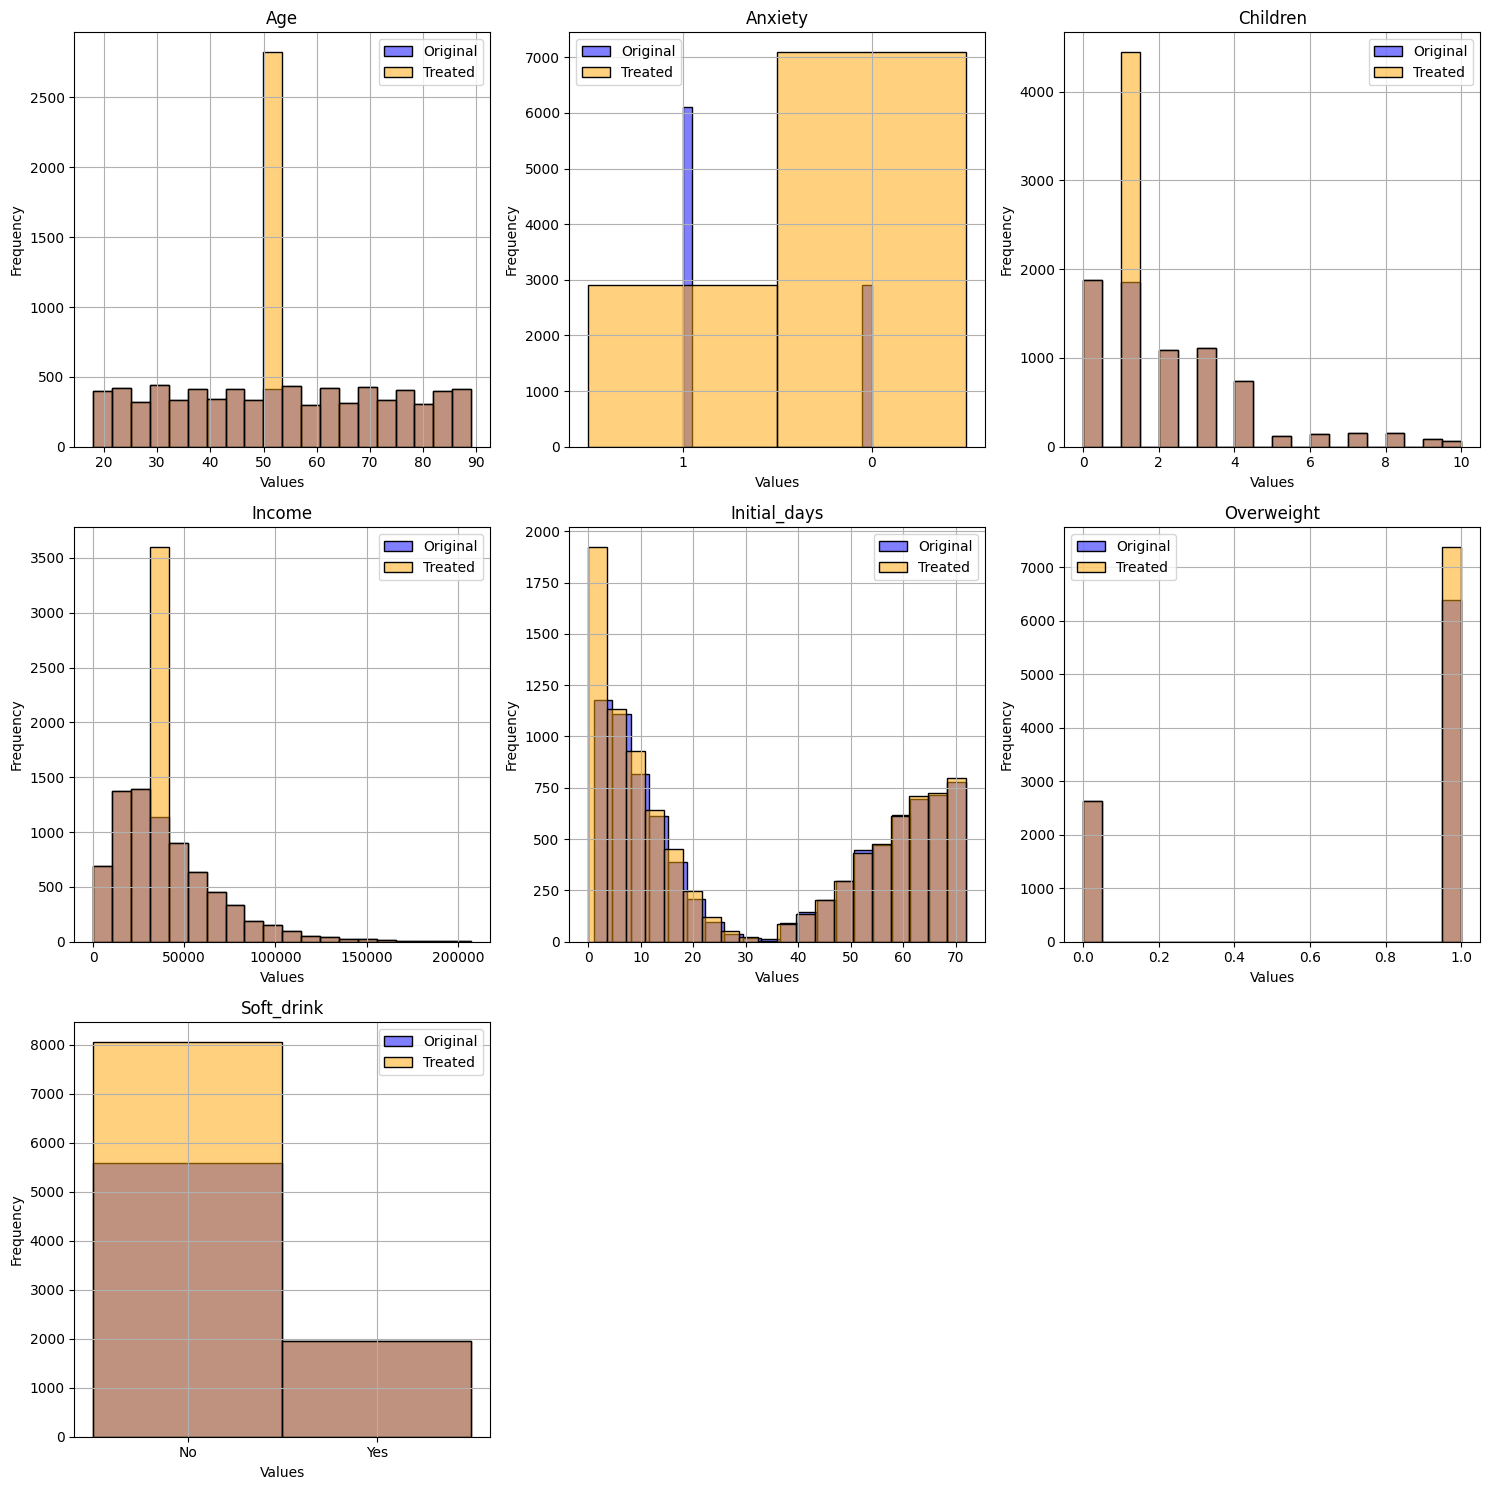

In [32]:
num_cols = len(reduced.columns)
num_rows = (num_cols + 2) // 3

# Create the subplot for the existing plots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axes = axes.flatten()

# Plot histograms for 'patients_df'
for i, column in enumerate(reduced.columns):
    sns.histplot(reduced[column], bins=20, ax=axes[i], color="blue", alpha=0.5)  # Overlay existing plots
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel("Values")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Plot histograms for 'patients_treated_df' and overlay them
for i, column in enumerate(reduced.columns):
    sns.histplot(patients_treated_df[column], bins=20, ax=axes[i], color="orange", alpha=0.5)  # Overlay new plots
    axes[i].legend(["Original", "Treated"])  # Add legend
    axes[i].grid(True)

# Hide any excess subplots
for j in range(num_cols, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### Outliers

Out-of-range values for `Lat` were clamped to between 18.9131 and 49.3844.

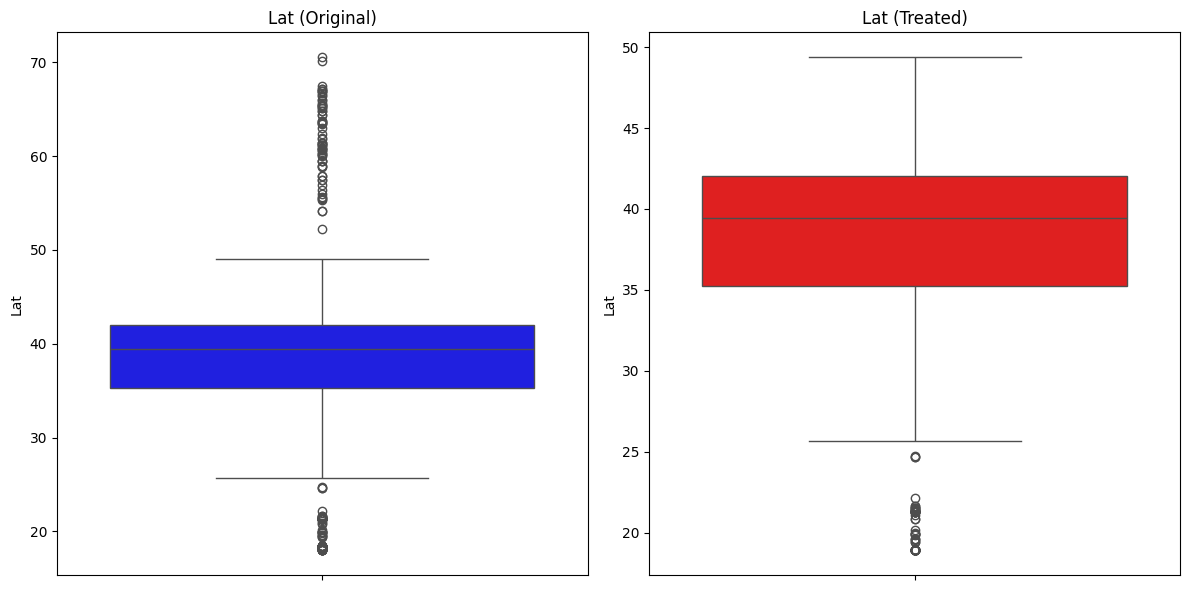

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=patients_df["Lat"], ax=axes[0], color="blue")
axes[0].set_title("Lat (Original)")

sns.boxplot(data=patients_treated_df["Lat"], ax=axes[1], color="red")
axes[1].set_title("Lat (Treated)")

plt.tight_layout()
plt.show()

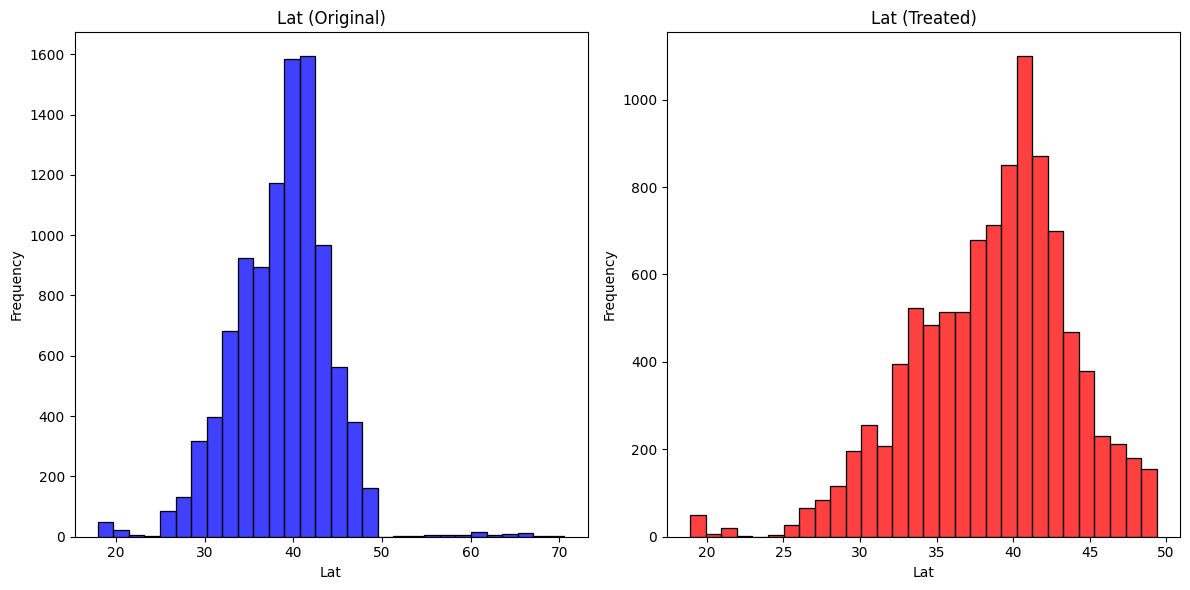

In [34]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram for patients_df
sns.histplot(data=patients_df["Lat"], bins=30, color="blue", ax=axes[0])
axes[0].set_title("Lat (Original)")
axes[0].set_xlabel("Lat")
axes[0].set_ylabel("Frequency")

# Plot the histogram for patients_treated_df
sns.histplot(data=patients_treated_df["Lat"], bins=30, color="red", ax=axes[1])
axes[1].set_title("Lat (Treated)")
axes[1].set_xlabel("Lat")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## D5: CSV of treated data

In [35]:
patients_treated_df.to_csv("medical_treated_data.csv")

## E1: Principal component analysis (PCA)

In [36]:
# ALL the quantitative variables in the dataset
continuous_variables = [
    "Lat",
    "Lng",
    "Population",
    "Children",
    "Age",
    "Income",
    "VitD_levels",
    "Doc_visits",
    "Full_meals_eaten",
    "VitD_supp",
    "Initial_days",
    "TotalCharge",
    "Additional_charges",
]

continuous_variables_df = patients_treated_df[continuous_variables]

scaler = StandardScaler()
std_df = scaler.fit_transform(continuous_variables_df)
pca = PCA()
pca.fit(std_df)

loading_matrix = pd.DataFrame(pca.components_, columns=continuous_variables)
print(loading_matrix)
print()

         Lat       Lng  Population  Children       Age    Income  VitD_levels  \
0  -0.019326 -0.004858    0.022556  0.003443  0.094527 -0.007685     0.558440   
1  -0.003172  0.015644   -0.026468  0.011313  0.699613 -0.004929    -0.067035   
2  -0.701053  0.053433    0.697467  0.028286  0.009579  0.049891    -0.053560   
3  -0.164124  0.272024   -0.022039 -0.218556 -0.010061 -0.274021     0.276178   
4   0.025002 -0.471082    0.100885  0.179824 -0.026783  0.486418     0.255529   
5   0.037355 -0.572805    0.113616  0.395148  0.004733 -0.266845    -0.209664   
6  -0.062295  0.476184   -0.140962  0.758700 -0.010307  0.337390     0.052691   
7  -0.066453 -0.023043   -0.037953 -0.304802 -0.004968  0.385685     0.062985   
8  -0.044735  0.178474   -0.074836 -0.237115  0.008559  0.439452    -0.401897   
9  -0.057239  0.234882   -0.010975  0.194552 -0.029483 -0.395829    -0.091646   
10  0.682291  0.241689    0.679372 -0.011347  0.001237  0.045769     0.007666   
11 -0.009112  0.011718   -0.

## PCA Discussion

In [37]:
eigenvalues = pca.explained_variance_

print("pca.explained_variance_ (eigenvalues)")
print(eigenvalues)
print()

print(f"Kaiser says keep: {np.sum(eigenvalues > 1)}")
print()

pca.explained_variance_ (eigenvalues)
[1.91728378 1.6182414  1.21337393 1.03220446 1.02754236 1.02254536
 0.99540785 0.98585912 0.98299461 0.97050486 0.77280339 0.37825169
 0.08428734]

Kaiser says keep: 6



The Kaiser Rule would tell us to keep 6 of the components.

10


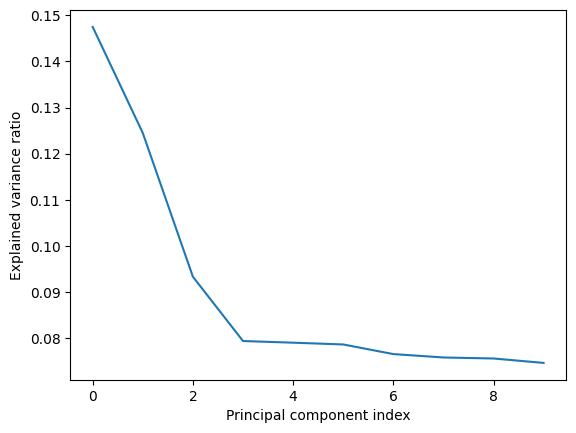

In [38]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA(n_components=0.9))])
pipe.fit(continuous_variables_df)
print(len(pipe["reducer"].components_))

var = pipe["reducer"].explained_variance_ratio_

plt.plot(var)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.show()

In [113]:
continuous_variables = [
    "Age",
    "Income",
    "VitD_levels",
    "Doc_visits",
    "Full_meals_eaten",
    "VitD_supp",
    "Initial_days",
    "TotalCharge",
    "Additional_charges",
    "Lat",
    "Lng",
    "Population",
    "Children",
]

continuous_variables_df = patients_treated_df[continuous_variables]

scaler = StandardScaler()
std_df = scaler.fit_transform(continuous_variables_df)
pca = PCA()
pca.fit(std_df)
print("pca.n_components_")
print(pca.n_components_)
print()

print("pca.components_.T")
print(pca.components_.T)
print()

print("pca.explained_variance_ratio_")
print(pca.explained_variance_ratio_)
print()

eigenvalues = pca.explained_variance_

print("pca.explained_variance_ (eigenvalues)")
print(eigenvalues)
print()

print(f"Kaiser says keep: {np.sum(eigenvalues > 1)}")
print()

print("pca.explained_variance_ratio_.cumsum()")
print(pca.explained_variance_ratio_.cumsum())

# sns.pairplot(continuous_variables_df)
# plt.show()

loading_matrix = pd.DataFrame(pca.components_.T, columns=continuous_variables)

# Display the loading matrix
print(loading_matrix)

pca.n_components_
13

pca.components_.T
[[ 9.45265690e-02  6.99613295e-01  9.57908528e-03 -1.00607574e-02
  -2.67832178e-02  4.73283681e-03 -1.03070711e-02 -4.96813549e-03
   8.55944931e-03 -2.94828098e-02  1.23708293e-03 -7.06604928e-01
   1.75434802e-02]
 [-7.68531164e-03 -4.92858772e-03  4.98913960e-02 -2.74021161e-01
   4.86417649e-01 -2.66844850e-01  3.37389711e-01  3.85684968e-01
   4.39452414e-01 -3.95829312e-01  4.57689251e-02 -7.26040684e-03
   3.25191178e-04]
 [ 5.58439670e-01 -6.70350875e-02 -5.35597387e-02  2.76178442e-01
   2.55529193e-01 -2.09664280e-01  5.26911183e-02  6.29846979e-02
  -4.01897013e-01 -9.16461086e-02  7.66623182e-03 -2.36570947e-02
  -5.63889974e-01]
 [-6.47955230e-03  1.31371157e-02  1.63638537e-02 -1.81359312e-01
   4.15418373e-01 -4.41428184e-01 -2.11569968e-01 -6.69752037e-01
   1.61316268e-01  2.73939492e-01 -6.90511902e-02 -5.57883118e-03
  -7.57603426e-04]
 [-5.37703733e-03  3.54135415e-02 -1.00530620e-01  4.62983571e-01
   3.87923307e-01  2.47311

## G: Web Sources

No third-party code sources were used.

H: References

* Centellegher, S. (2020, January 27). *How to compute PCA loadings and the loading matrix with scikit-learn.* Retrieved February 14, 2024, from scentellegher.github.io: [https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html](https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html)
* OpenAI. (2024, February 14). What range of latitude and longitude do the entire 50 states in the United States of America cover? [Response by ChatGPT]. Retrieved February 14, 2024, from [https://www.chatgpt.com/](https://www.chatgpt.com/)